# RTML 2025 | A4 | Masked Auto Encoder Assignment

## Final Report
-----------------
### Name: Arya Shah

### StudentID: st125462

This notebook consists of solutions for the following exercises:

(⚠️ Note that this is a Jupyter Notebook compiled from the individual python scripts and is not intended to be run as is)

1. With MNIST dataset, experiment with different patch_sizes, masking ratio on the reconstruction part. Describe what you have learnt
Here is my best results, see if you can beat me✅

The original images MAE - Original

My reconstructed images MAE - recon

2. Now since we have trained our MAE. Let's make use of it! ✅

Once the autoencoder is trained, the learned encoder can be repurposed for downstream tasks like image classification.

How It Works:

- Encoder Extraction: After pretraining, the encoder is detached from the decoder and fine-tuned for classification.✅

- Class Token Addition: A classification token (CLS) is added to the input patch sequence. This token interacts with other patches during encoding and aggregates the final representation.✅

- Linear Classifier: A linear classifier (MLP head) is attached on top of the encoder to map the latent representation to class labels.✅

With MNIST dataset, train a classifier (Part2)and report results. (Classifier class is already given below) ✅

```python
# Transition to a downstream task ✅
class ViT_Classifier(torch.nn.Module):
    def __init__(self, encoder : MAE_Encoder, num_classes=10) -> None:
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = torch.nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits
```

3. Experiment with a different dataset, CIFAR-10. Discuss the similarity and differences of the results of both datasets. Suggest possible improvements you could potentially make to CIFAR-10 in the future. ✅

---------------------

Final Submission: The report
Describe your experiments and their results. The report should be turned in on Teal Classroom before the deadline. ✅


# 1. With MNIST dataset, experiment with different patch_sizes, masking ratio on the reconstruction part. Describe what you have learnt Here is my best results, see if you can beat me ✅

Script used `mae_mnist_training.py`

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from A4_MAE import MAE_ViT, setup_seed, denormalize
import numpy as np

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def train_mae(patch_size, mask_ratio, num_epochs=25, batch_size=128, device='cuda'):
    # Create directories for saving plots
    plot_dir = f'plots/mae_mnist_patch{patch_size}_mask{mask_ratio}'
    ensure_dir(plot_dir)
    ensure_dir(os.path.join(plot_dir, 'reconstructions'))
    
    # Data loading
    transform = Compose([
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    
    train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    # Model setup
    model = MAE_ViT(
        image_size=28,  # MNIST is 28x28
        patch_size=patch_size,
        emb_dim=192,
        encoder_layer=12,
        encoder_head=3,
        decoder_layer=4,
        decoder_head=3,
        mask_ratio=mask_ratio
    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1.5e-4)
    criterion = nn.MSELoss()
    
    # Training loop
    best_loss = float('inf')
    losses = []  # Store losses for plotting
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (images, _) in enumerate(progress_bar):
            images = images.to(device)
            
            # Forward pass
            reconstructed, _ = model(images)
            loss = criterion(reconstructed, images)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
            
            # Save reconstruction samples every 200 batches
            if batch_idx % 200 == 0:
                with torch.no_grad():
                    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
                    for i in range(4):
                        reconstructed_vis, _ = model(images[i:i+1])
                        orig_img = denormalize(images[i].cpu())
                        recon_img = denormalize(reconstructed_vis[0].cpu())
                        
                        axes[0, i].imshow(orig_img.squeeze(), cmap='gray')
                        axes[0, i].axis('off')
                        axes[0, i].set_title('Original')
                        
                        axes[1, i].imshow(recon_img.squeeze(), cmap='gray')
                        axes[1, i].axis('off')
                        axes[1, i].set_title('Reconstructed')
                    
                    plt.tight_layout()
                    plt.savefig(os.path.join(plot_dir, 'reconstructions', f'epoch_{epoch}_batch_{batch_idx}.png'))
                    plt.close()
        
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')
        
        # Plot and save loss curve
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epoch + 2), losses, 'b-')
        plt.title(f'Training Loss (patch_size={patch_size}, mask_ratio={mask_ratio})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.savefig(os.path.join(plot_dir, 'loss_curve.png'))
        plt.close()
        
        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, f'mae_mnist_patch{patch_size}_mask{mask_ratio}_best.pth')
    
    return model

if __name__ == "__main__":
    setup_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Experiment with different configurations
    configs = [
        {'patch_size': 2, 'mask_ratio': 0.75},  # baseline
        {'patch_size': 4, 'mask_ratio': 0.75},  # larger patches
        {'patch_size': 2, 'mask_ratio': 0.85},  # more masking
        {'patch_size': 4, 'mask_ratio': 0.85},  # larger patches + more masking
    ]
    
    for config in configs:
        print(f"\nTraining MAE with patch_size={config['patch_size']}, mask_ratio={config['mask_ratio']}")
        model = train_mae(
            patch_size=config['patch_size'],
            mask_ratio=config['mask_ratio'],
            device=device
        )


```bash
(base) jupyter-st125462@puffer:~/RTML/A4$ python mae_mnist_training.py
/home/jupyter-st125462/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/jupyter-st125462/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.08it/s]
In epoch 0, average traning loss is 0.5465917753729415.
=================== EPOCH:  1  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:09<00:00, 18.87it/s]
In epoch 1, average traning loss is 0.3796648606657982.
=================== EPOCH:  2  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.97it/s]
In epoch 2, average traning loss is 0.31179066192596516.
=================== EPOCH:  3  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:09<00:00, 19.37it/s]
In epoch 3, average traning loss is 0.2802716832845769.
=================== EPOCH:  4  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 16.63it/s]
In epoch 4, average traning loss is 0.2737688419032604.
=================== EPOCH:  5  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.22it/s]
In epoch 5, average traning loss is 0.2697553132125672.
=================== EPOCH:  6  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 18.60it/s]
In epoch 6, average traning loss is 0.267296017484462.
=================== EPOCH:  7  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:12<00:00, 15.66it/s]
In epoch 7, average traning loss is 0.26577108955763756.
=================== EPOCH:  8  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 16.70it/s]
In epoch 8, average traning loss is 0.2647874166673802.
=================== EPOCH:  9  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 17.07it/s]
In epoch 9, average traning loss is 0.2638680625786173.
=================== EPOCH:  10  ===================

Training MAE with patch_size=2, mask_ratio=0.75
Epoch 1/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:48<00:00,  9.70it/s, loss=0.177]
Epoch 1, Average Loss: 0.2180
Epoch 2/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:49<00:00,  9.44it/s, loss=0.193]
Epoch 2, Average Loss: 0.1908
Epoch 3/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:49<00:00,  9.45it/s, loss=0.158]
Epoch 3, Average Loss: 0.1749
Epoch 4/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.32it/s, loss=0.12]
Epoch 4, Average Loss: 0.1416
Epoch 5/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.34it/s, loss=0.0875]
Epoch 5, Average Loss: 0.1073
Epoch 6/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.27it/s, loss=0.0731]
Epoch 6, Average Loss: 0.0821
Epoch 7/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:51<00:00,  9.17it/s, loss=0.0617]
Epoch 7, Average Loss: 0.0688
Epoch 8/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.27it/s, loss=0.0605]
Epoch 8, Average Loss: 0.0624
Epoch 9/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:51<00:00,  9.18it/s, loss=0.0536]
Epoch 9, Average Loss: 0.0579
Epoch 10/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.26it/s, loss=0.0544]
Epoch 10, Average Loss: 0.0553
Epoch 11/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.20it/s, loss=0.0508]
Epoch 11, Average Loss: 0.0535
Epoch 12/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:51<00:00,  9.16it/s, loss=0.0475]
Epoch 12, Average Loss: 0.0515
Epoch 13/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.35it/s, loss=0.0483]
Epoch 13, Average Loss: 0.0502
Epoch 14/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.31it/s, loss=0.0438]
Epoch 14, Average Loss: 0.0491
Epoch 15/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.32it/s, loss=0.0426]
Epoch 15, Average Loss: 0.0481
Epoch 16/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.35it/s, loss=0.0453]
Epoch 16, Average Loss: 0.0473
Epoch 17/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.25it/s, loss=0.0434]
Epoch 17, Average Loss: 0.0464
Epoch 18/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.33it/s, loss=0.0429]
Epoch 18, Average Loss: 0.0457
Epoch 19/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.24it/s, loss=0.0427]
Epoch 19, Average Loss: 0.0452
Epoch 20/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.31it/s, loss=0.0476]
Epoch 20, Average Loss: 0.0446
Epoch 21/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.28it/s, loss=0.0409]
Epoch 21, Average Loss: 0.0438
Epoch 22/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.23it/s, loss=0.0431]
Epoch 22, Average Loss: 0.0434
Epoch 23/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.23it/s, loss=0.0451]
Epoch 23, Average Loss: 0.0431
Epoch 24/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.22it/s, loss=0.0387]
Epoch 24, Average Loss: 0.0425
Epoch 25/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:50<00:00,  9.36it/s, loss=0.0417]
Epoch 25, Average Loss: 0.0421

Training MAE with patch_size=4, mask_ratio=0.75
Epoch 1/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.67it/s, loss=0.194]
Epoch 1, Average Loss: 0.2149
Epoch 2/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.86it/s, loss=0.172]
Epoch 2, Average Loss: 0.1837
Epoch 3/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:33<00:00, 14.12it/s, loss=0.142]
Epoch 3, Average Loss: 0.1626
Epoch 4/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:34<00:00, 13.68it/s, loss=0.143]
Epoch 4, Average Loss: 0.1426
Epoch 5/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:33<00:00, 14.05it/s, loss=0.139]
Epoch 5, Average Loss: 0.1289
Epoch 6/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:33<00:00, 14.15it/s, loss=0.105]
Epoch 6, Average Loss: 0.1179
Epoch 7/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.67it/s, loss=0.106]
Epoch 7, Average Loss: 0.1091
Epoch 8/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:33<00:00, 13.99it/s, loss=0.0998]
Epoch 8, Average Loss: 0.1031
Epoch 9/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:30<00:00, 15.26it/s, loss=0.0906]
Epoch 9, Average Loss: 0.0978
Epoch 10/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.99it/s, loss=0.0984]
Epoch 10, Average Loss: 0.0944
Epoch 11/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.71it/s, loss=0.0854]
Epoch 11, Average Loss: 0.0915
Epoch 12/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.38it/s, loss=0.0806]
Epoch 12, Average Loss: 0.0893
Epoch 13/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:30<00:00, 15.59it/s, loss=0.0926]
Epoch 13, Average Loss: 0.0877
Epoch 14/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:30<00:00, 15.28it/s, loss=0.0851]
Epoch 14, Average Loss: 0.0857
Epoch 15/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 15.07it/s, loss=0.0911]
Epoch 15, Average Loss: 0.0844
Epoch 16/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:32<00:00, 14.56it/s, loss=0.0791]
Epoch 16, Average Loss: 0.0827
Epoch 17/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:32<00:00, 14.43it/s, loss=0.0848]
Epoch 17, Average Loss: 0.0823
Epoch 18/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.74it/s, loss=0.0775]
Epoch 18, Average Loss: 0.0813
Epoch 19/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:33<00:00, 14.06it/s, loss=0.0896]
Epoch 19, Average Loss: 0.0802
Epoch 20/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:32<00:00, 14.21it/s, loss=0.08]
Epoch 20, Average Loss: 0.0797
Epoch 21/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:33<00:00, 14.07it/s, loss=0.0788]
Epoch 21, Average Loss: 0.0787
Epoch 22/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:33<00:00, 14.05it/s, loss=0.0816]
Epoch 22, Average Loss: 0.0781
Epoch 23/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:33<00:00, 14.19it/s, loss=0.0783]
Epoch 23, Average Loss: 0.0773
Epoch 24/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:33<00:00, 14.01it/s, loss=0.08]
Epoch 24, Average Loss: 0.0769
Epoch 25/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:34<00:00, 13.51it/s, loss=0.0731]
Epoch 25, Average Loss: 0.0764

Training MAE with patch_size=2, mask_ratio=0.85
Epoch 1/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:44<00:00, 10.62it/s, loss=0.219]
Epoch 1, Average Loss: 0.2460
Epoch 2/25:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 463/469 [00:43<00:00, 11.36it/s, loss=0.213]Epoch 2/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:44<00:00, 10.63it/s, loss=0.195]
Epoch 2, Average Loss: 0.2162
Epoch 3/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:43<00:00, 10.69it/s, loss=0.199]
Epoch 3, Average Loss: 0.2002
Epoch 4/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:44<00:00, 10.50it/s, loss=0.162]
Epoch 4, Average Loss: 0.1730
Epoch 5/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:44<00:00, 10.49it/s, loss=0.129]
Epoch 5, Average Loss: 0.1501
Epoch 6/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:43<00:00, 10.76it/s, loss=0.129]
Epoch 6, Average Loss: 0.1329
Epoch 7/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:44<00:00, 10.57it/s, loss=0.116]
Epoch 7, Average Loss: 0.1203
Epoch 8/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:44<00:00, 10.63it/s, loss=0.107]
Epoch 8, Average Loss: 0.1112
Epoch 9/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:43<00:00, 10.69it/s, loss=0.105]
Epoch 9, Average Loss: 0.1041
Epoch 10/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:44<00:00, 10.47it/s, loss=0.0965]
Epoch 10, Average Loss: 0.0997
Epoch 11/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:44<00:00, 10.65it/s, loss=0.0959]
Epoch 11, Average Loss: 0.0956
Epoch 12/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:45<00:00, 10.23it/s, loss=0.0849]
Epoch 12, Average Loss: 0.0922
Epoch 13/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:45<00:00, 10.24it/s, loss=0.0882]
Epoch 13, Average Loss: 0.0895
Epoch 14/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:46<00:00, 10.12it/s, loss=0.087]
Epoch 14, Average Loss: 0.0868
Epoch 15/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:46<00:00, 10.16it/s, loss=0.0871]
Epoch 15, Average Loss: 0.0848
Epoch 16/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:46<00:00, 10.16it/s, loss=0.0851]
Epoch 16, Average Loss: 0.0834
Epoch 17/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:46<00:00, 10.08it/s, loss=0.0859]
Epoch 17, Average Loss: 0.0816
Epoch 18/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:46<00:00,  9.99it/s, loss=0.0753]
Epoch 18, Average Loss: 0.0805
Epoch 19/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:47<00:00,  9.91it/s, loss=0.0804]
Epoch 19, Average Loss: 0.0799
Epoch 20/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:45<00:00, 10.21it/s, loss=0.0779]
Epoch 20, Average Loss: 0.0791
Epoch 21/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:44<00:00, 10.58it/s, loss=0.0766]
Epoch 21, Average Loss: 0.0779
Epoch 22/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:45<00:00, 10.36it/s, loss=0.0909]
Epoch 22, Average Loss: 0.0769
Epoch 23/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:46<00:00,  9.99it/s, loss=0.0778]
Epoch 23, Average Loss: 0.0762
Epoch 24/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:45<00:00, 10.32it/s, loss=0.0789]
Epoch 24, Average Loss: 0.0755
Epoch 25/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:47<00:00,  9.77it/s, loss=0.0753]
Epoch 25, Average Loss: 0.0752

Training MAE with patch_size=4, mask_ratio=0.85
Epoch 1/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.32it/s, loss=0.229]
Epoch 1, Average Loss: 0.2428
Epoch 2/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.30it/s, loss=0.207]
Epoch 2, Average Loss: 0.2156
Epoch 3/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.80it/s, loss=0.187]
Epoch 3, Average Loss: 0.2006
Epoch 4/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.81it/s, loss=0.177]
Epoch 4, Average Loss: 0.1845
Epoch 5/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.74it/s, loss=0.163]
Epoch 5, Average Loss: 0.1732
Epoch 6/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 15.02it/s, loss=0.164]
Epoch 6, Average Loss: 0.1637
Epoch 7/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.77it/s, loss=0.169]
Epoch 7, Average Loss: 0.1566
Epoch 8/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.68it/s, loss=0.142]
Epoch 8, Average Loss: 0.1511
Epoch 9/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.98it/s, loss=0.133]
Epoch 9, Average Loss: 0.1466
Epoch 10/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:32<00:00, 14.55it/s, loss=0.142]
Epoch 10, Average Loss: 0.1435
Epoch 11/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.82it/s, loss=0.139]
Epoch 11, Average Loss: 0.1407
Epoch 12/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:32<00:00, 14.33it/s, loss=0.133]
Epoch 12, Average Loss: 0.1390
Epoch 13/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:33<00:00, 14.20it/s, loss=0.146]
Epoch 13, Average Loss: 0.1368
Epoch 14/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.85it/s, loss=0.139]
Epoch 14, Average Loss: 0.1359
Epoch 15/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.95it/s, loss=0.143]
Epoch 15, Average Loss: 0.1345
Epoch 16/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:32<00:00, 14.65it/s, loss=0.133]
Epoch 16, Average Loss: 0.1329
Epoch 17/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:31<00:00, 14.73it/s, loss=0.133]
Epoch 17, Average Loss: 0.1320
Epoch 18/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.62it/s, loss=0.13]
Epoch 18, Average Loss: 0.1310
Epoch 19/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:30<00:00, 15.39it/s, loss=0.131]
Epoch 19, Average Loss: 0.1303
Epoch 20/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 16.04it/s, loss=0.142]
Epoch 20, Average Loss: 0.1295
Epoch 21/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:30<00:00, 15.56it/s, loss=0.132]
Epoch 21, Average Loss: 0.1286
Epoch 22/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 16.16it/s, loss=0.129]
Epoch 22, Average Loss: 0.1285
Epoch 23/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.99it/s, loss=0.132]
Epoch 23, Average Loss: 0.1276
Epoch 24/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 16.12it/s, loss=0.118]
Epoch 24, Average Loss: 0.1271
Epoch 25/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.95it/s, loss=0.13]
Epoch 25, Average Loss: 0.1265
```

# Summary of Analysis

## Experimental Configurations
- Config 1: patch_size=2, mask_ratio=0.75 (baseline)

25th Epoch Results:
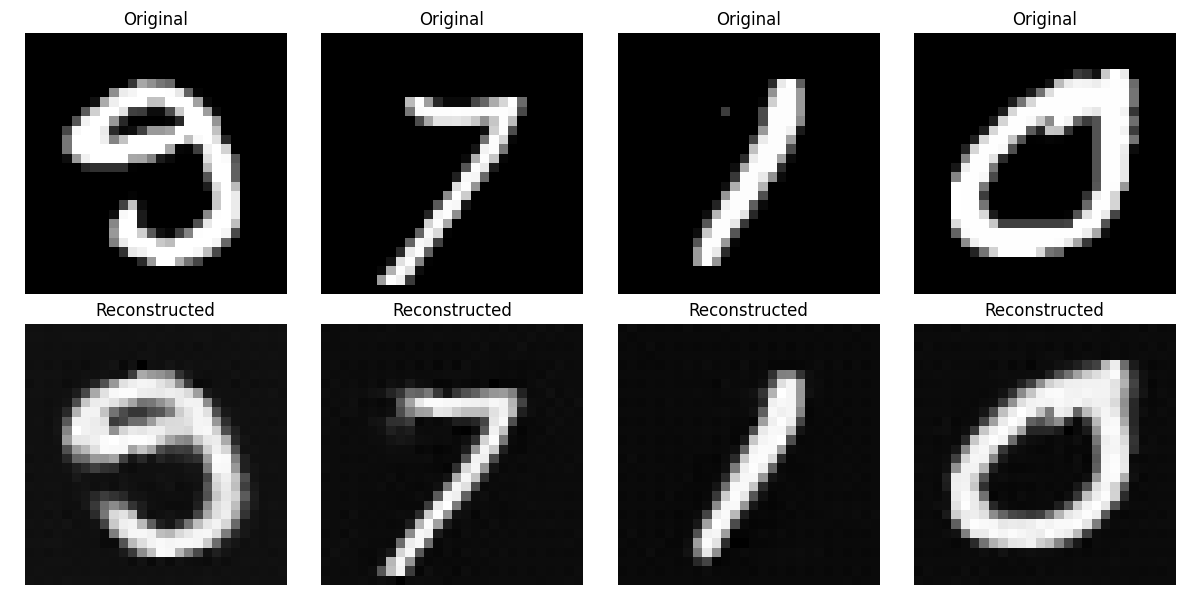

Loss Curve:
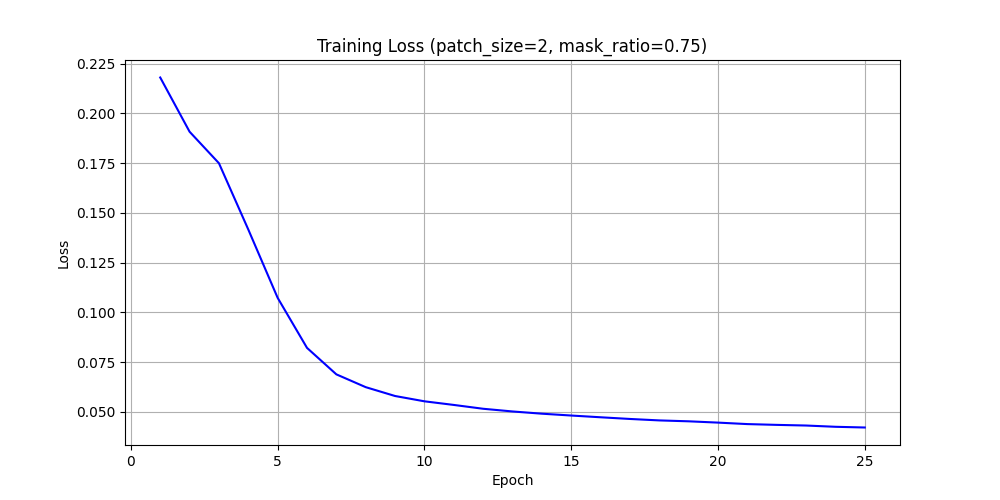

- Config 2: patch_size=4, mask_ratio=0.75 (larger patches)

25th Epoch Results:
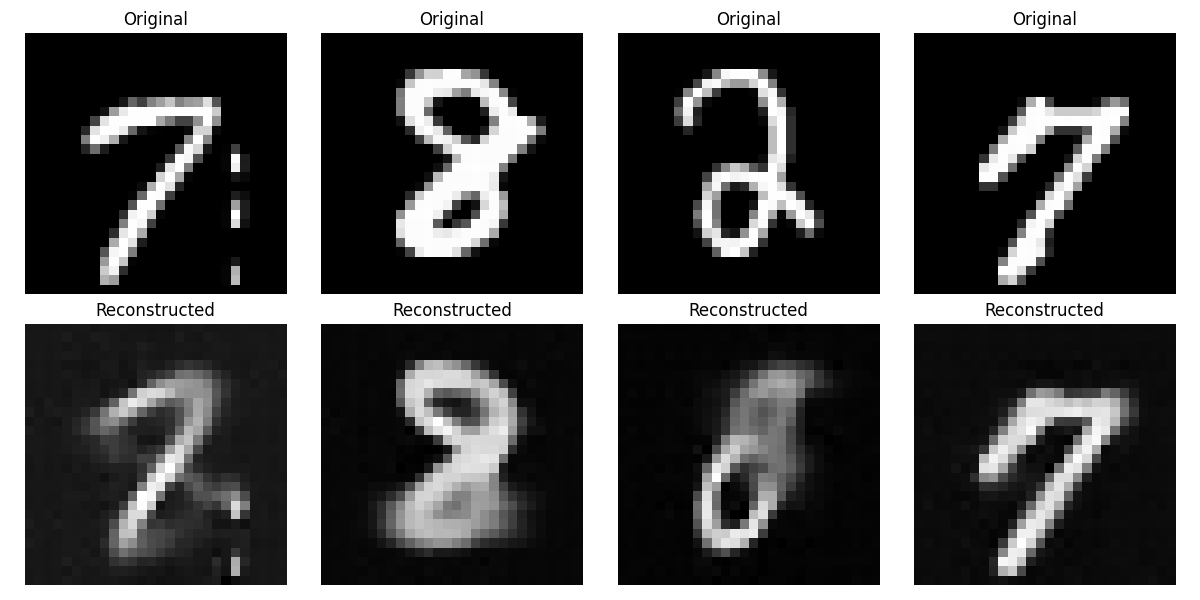

Loss Curve:
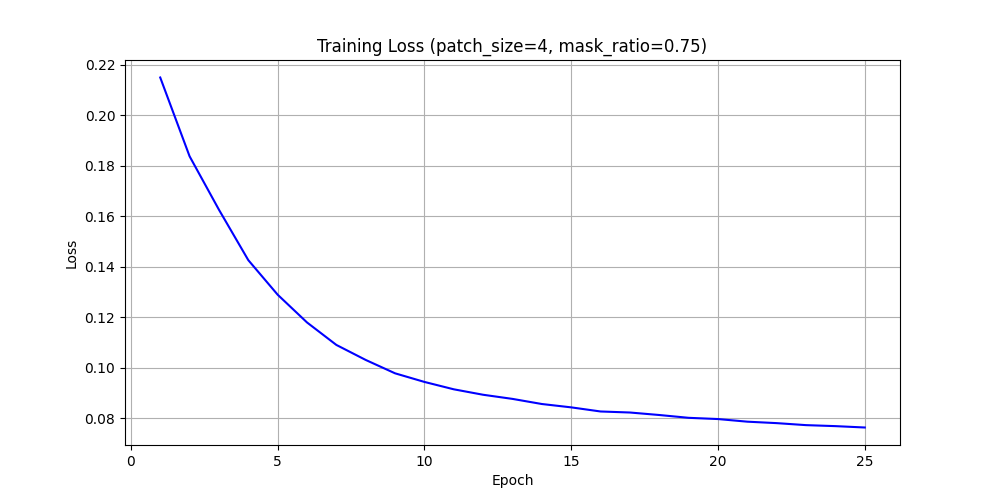

- Config 3: patch_size=2, mask_ratio=0.85 (more masking)

25th Epoch Results:
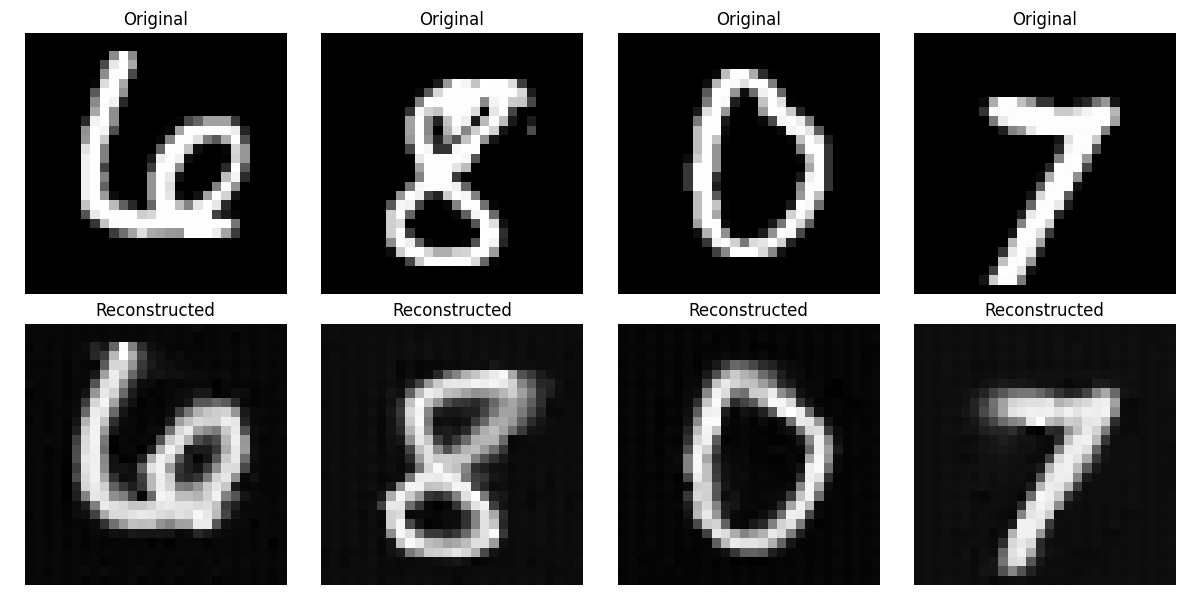

Loss Curve:
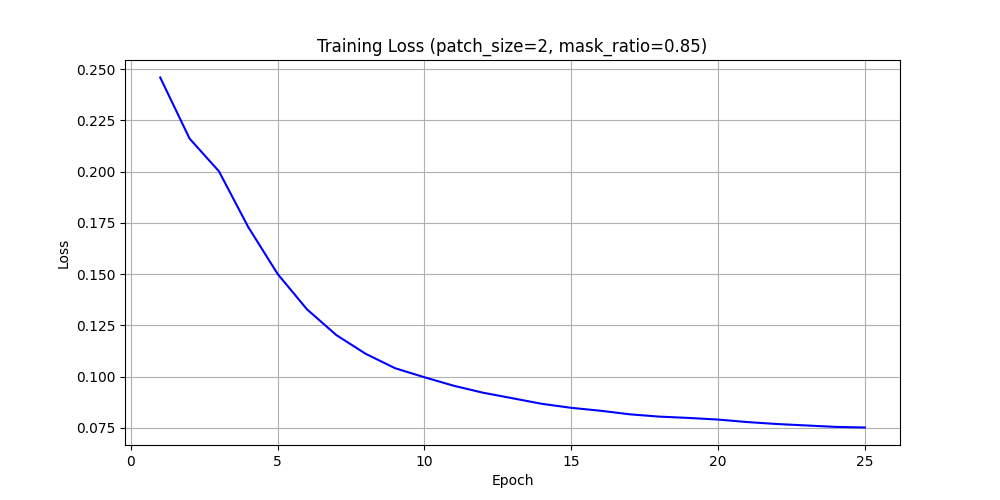

- Config 4: patch_size=4, mask_ratio=0.85 (larger patches + more masking)

25th Epoch Results:
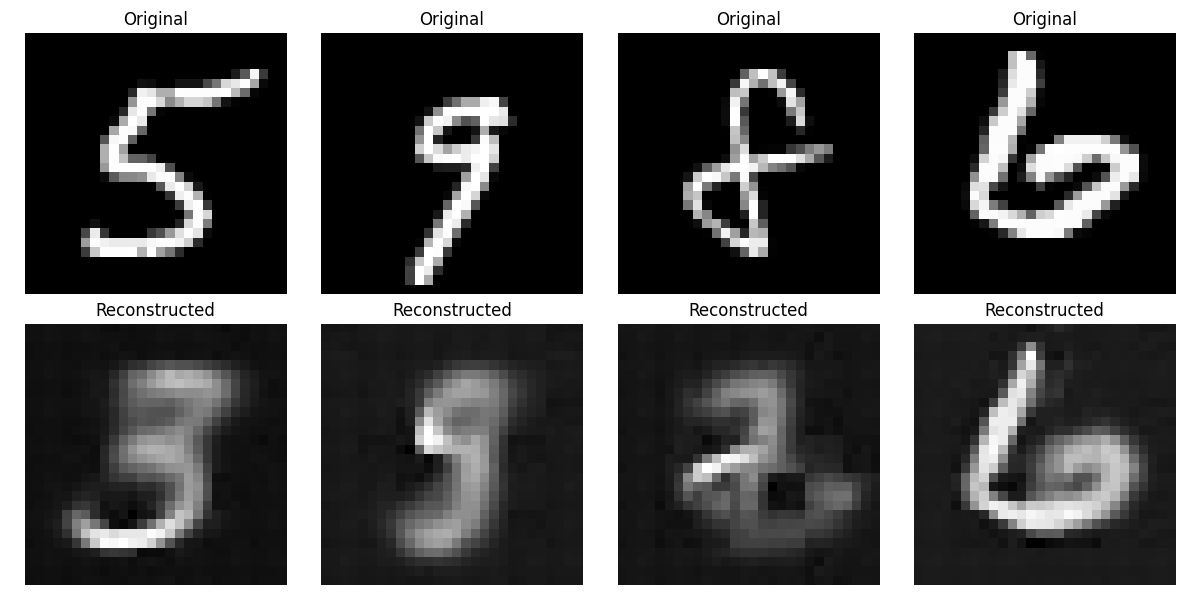

Loss Curve:
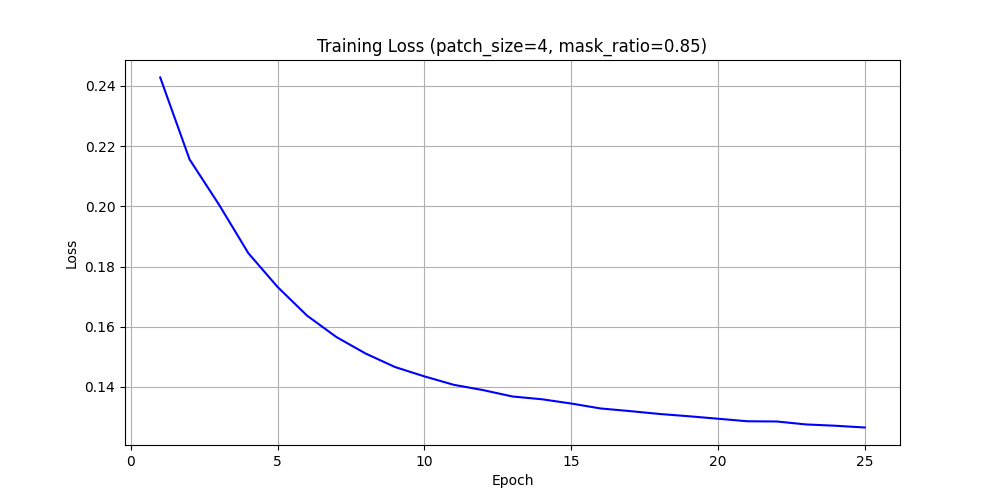

## Key Observations

1. **Final Loss Values**:
- Config 1: ~0.0421 (lowest)
- Config 2: ~0.0764 (moderate)
- Config 3: ~0.0752 (moderate)
- Config 4: ~0.1265 (highest)

2. **Convergence Speed**:
- Smaller patch size (2) configurations converged more slowly but achieved better final results
- Larger patch size (4) configurations showed faster initial convergence but higher final loss

3. **Impact of Parameters**:
- Patch Size: Larger patches (4x4) led to faster training but higher reconstruction error
- Mask Ratio: Higher mask ratio (0.85) resulted in higher reconstruction loss compared to 0.75

## Conclusions

1. **Optimal Configuration**: The baseline configuration (patch_size=2, mask_ratio=0.75) performed best overall, achieving the lowest final loss of 0.0421.

2. **Patch Size Effect**: 
- Smaller patches (2x2) allow for more detailed reconstruction
- Larger patches (4x4) trade reconstruction quality for computational efficiency

3. **Masking Ratio Impact**:
- Lower masking ratio (0.75) generally performed better than higher ratio (0.85)
- Higher masking makes the reconstruction task more challenging

4. **Trade-offs**:
- There's a clear trade-off between reconstruction quality and computational efficiency
- Choose smaller patches and lower mask ratio for better reconstruction
- Choose larger patches if training speed is prioritized over reconstruction quality

# 2. Now since we have trained our MAE. Let's make use of it! ✅

Once the autoencoder is trained, the learned encoder can be repurposed for downstream tasks like image classification. ✅

Script used: `mnist_classifier.py`

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import os
from A4_MAE import MAE_ViT, ViT_Classifier, setup_seed

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def train_classifier(pretrained_mae_path, patch_size, num_epochs=25, batch_size=128, device='cuda'):
    # Create directories for saving plots
    plot_dir = f'plots/mnist_classifier_patch{patch_size}'
    ensure_dir(plot_dir)
    
    # Data loading
    transform = Compose([
        ToTensor(),
        Normalize(mean=(0.5,), std=(0.5,))
    ])
    
    train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Load pretrained MAE
    mae = MAE_ViT(
        image_size=28,
        patch_size=patch_size,
        emb_dim=192,
        encoder_layer=12,
        encoder_head=3,
        decoder_layer=4,
        decoder_head=3,
        mask_ratio=0.75
    ).to(device)
    
    checkpoint = torch.load(pretrained_mae_path, map_location=device)
    mae.load_state_dict(checkpoint['model_state_dict'])
    
    # Create classifier using pretrained encoder
    model = ViT_Classifier(mae.encoder, num_classes=10).to(device)
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    # Training loop
    best_acc = 0.0
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': 100.*correct/total
            })
        
        train_acc = 100.*correct/total
        train_losses.append(total_loss/len(train_loader))
        train_accs.append(train_acc)
        
        # Evaluation
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        test_acc = 100.*correct/total
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(test_acc)
        
        print(f'\nEpoch {epoch+1}:')
        print(f'Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_acc:.2f}%')
        
        # Plot and save training curves
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), train_losses, 'b-', label='Train')
        plt.plot(range(1, epoch + 2), test_losses, 'r-', label='Test')
        plt.title('Loss Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), train_accs, 'b-', label='Train')
        plt.plot(range(1, epoch + 2), test_accs, 'r-', label='Test')
        plt.title('Accuracy Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, 'training_curves.png'))
        plt.close()
        
        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            
            # Plot confusion matrix for best model
            cm = confusion_matrix(all_labels, all_preds)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix (Test Acc: {test_acc:.2f}%)')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.savefig(os.path.join(plot_dir, 'confusion_matrix.png'))
            plt.close()
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': best_acc,
            }, f'mnist_classifier_patch{patch_size}_best.pth')
    
    return model, best_acc

if __name__ == "__main__":
    setup_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Train classifiers using different pretrained MAE models
    configs = [
        {'patch_size': 2, 'mask_ratio': 0.75},
        {'patch_size': 4, 'mask_ratio': 0.75},
        {'patch_size': 2, 'mask_ratio': 0.85},
        {'patch_size': 4, 'mask_ratio': 0.85},
    ]
    
    results = {}
    for config in configs:
        patch_size = config['patch_size']
        mask_ratio = config['mask_ratio']
        mae_path = f'mae_mnist_patch{patch_size}_mask{mask_ratio}_best.pth'
        
        print(f"\nTraining classifier using MAE with patch_size={patch_size}, mask_ratio={mask_ratio}")
        _, acc = train_classifier(mae_path, patch_size, device=device)
        results[f"patch{patch_size}_mask{mask_ratio}"] = acc
    
    # Print final results
    print("\nFinal Results:")
    for config, acc in results.items():
        print(f"{config}: {acc:.2f}%")


```bash
(base) jupyter-st125462@puffer:~/RTML/A4$ python mnist_classifier.py
/home/jupyter-st125462/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/jupyter-st125462/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 16.61it/s]
In epoch 0, average traning loss is 0.5465917753729415.
=================== EPOCH:  1  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 16.65it/s]
In epoch 1, average traning loss is 0.3796648606657982.
=================== EPOCH:  2  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.23it/s]
In epoch 2, average traning loss is 0.31179066192596516.
=================== EPOCH:  3  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 16.65it/s]
In epoch 3, average traning loss is 0.2802716832845769.
=================== EPOCH:  4  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.31it/s]
In epoch 4, average traning loss is 0.2737688419032604.
=================== EPOCH:  5  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 16.78it/s]
In epoch 5, average traning loss is 0.2697553132125672.
=================== EPOCH:  6  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 16.88it/s]
In epoch 6, average traning loss is 0.267296017484462.
=================== EPOCH:  7  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 16.57it/s]
In epoch 7, average traning loss is 0.26577108955763756.
=================== EPOCH:  8  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:10<00:00, 17.12it/s]
In epoch 8, average traning loss is 0.2647874166673802.
=================== EPOCH:  9  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 16.03it/s]
In epoch 9, average traning loss is 0.2638680625786173.
=================== EPOCH:  10  ===================

Training classifier using MAE with patch_size=2, mask_ratio=0.75
/home/jupyter-st125462/RTML/A4/mnist_classifier.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_mae_path, map_location=device)
Epoch 1/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:32<00:00,  5.08it/s, loss=0.0777, acc=95.8]

Epoch 1:
Train Loss: 0.1495 | Train Acc: 95.77%
Test Loss: 0.0640 | Test Acc: 98.12%
Epoch 2/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:05<00:00,  3.75it/s, loss=0.0649, acc=98.6]

Epoch 2:
Train Loss: 0.0488 | Train Acc: 98.59%
Test Loss: 0.0380 | Test Acc: 98.79%
Epoch 3/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:05<00:00,  3.73it/s, loss=0.0359, acc=98.8]

Epoch 3:
Train Loss: 0.0381 | Train Acc: 98.83%
Test Loss: 0.0410 | Test Acc: 98.82%
Epoch 4/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:06<00:00,  3.69it/s, loss=0.0445, acc=99.1]

Epoch 4:
Train Loss: 0.0312 | Train Acc: 99.06%
Test Loss: 0.0552 | Test Acc: 98.31%
Epoch 5/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.77it/s, loss=0.0254, acc=99.2]

Epoch 5:
Train Loss: 0.0276 | Train Acc: 99.15%
Test Loss: 0.0373 | Test Acc: 98.93%
Epoch 6/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:57<00:00,  3.99it/s, loss=0.00416, acc=99.3]

Epoch 6:
Train Loss: 0.0230 | Train Acc: 99.28%
Test Loss: 0.0401 | Test Acc: 98.80%
Epoch 7/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:07<00:00,  3.67it/s, loss=0.0684, acc=99.3]

Epoch 7:
Train Loss: 0.0213 | Train Acc: 99.31%
Test Loss: 0.0439 | Test Acc: 98.67%
Epoch 8/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:08<00:00,  3.65it/s, loss=0.00123, acc=99.4]

Epoch 8:
Train Loss: 0.0183 | Train Acc: 99.44%
Test Loss: 0.0357 | Test Acc: 98.97%
Epoch 9/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:08<00:00,  3.66it/s, loss=0.00611, acc=99.4]

Epoch 9:
Train Loss: 0.0189 | Train Acc: 99.39%
Test Loss: 0.0311 | Test Acc: 99.09%
Epoch 10/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:07<00:00,  3.67it/s, loss=0.00306, acc=99.5]

Epoch 10:
Train Loss: 0.0172 | Train Acc: 99.46%
Test Loss: 0.0262 | Test Acc: 99.25%
Epoch 11/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:09<00:00,  3.62it/s, loss=0.00108, acc=99.5]

Epoch 11:
Train Loss: 0.0145 | Train Acc: 99.53%
Test Loss: 0.0321 | Test Acc: 99.11%
Epoch 12/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:08<00:00,  3.64it/s, loss=0.00297, acc=99.5]

Epoch 12:
Train Loss: 0.0145 | Train Acc: 99.54%
Test Loss: 0.0418 | Test Acc: 98.84%
Epoch 13/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:09<00:00,  3.61it/s, loss=0.0239, acc=99.6]

Epoch 13:
Train Loss: 0.0141 | Train Acc: 99.56%
Test Loss: 0.0343 | Test Acc: 98.99%
Epoch 14/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:10<00:00,  3.59it/s, loss=0.0362, acc=99.5]

Epoch 14:
Train Loss: 0.0146 | Train Acc: 99.52%
Test Loss: 0.0297 | Test Acc: 99.18%
Epoch 15/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:34<00:00,  4.96it/s, loss=0.00868, acc=99.6]

Epoch 15:
Train Loss: 0.0121 | Train Acc: 99.61%
Test Loss: 0.0342 | Test Acc: 99.04%
Epoch 16/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:28<00:00,  5.30it/s, loss=0.00416, acc=99.6]

Epoch 16:
Train Loss: 0.0120 | Train Acc: 99.61%
Test Loss: 0.0328 | Test Acc: 99.13%
Epoch 17/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:28<00:00,  5.27it/s, loss=0.0195, acc=99.7]

Epoch 17:
Train Loss: 0.0094 | Train Acc: 99.70%
Test Loss: 0.0299 | Test Acc: 99.13%
Epoch 18/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:30<00:00,  5.20it/s, loss=0.000649, acc=99.6]

Epoch 18:
Train Loss: 0.0112 | Train Acc: 99.64%
Test Loss: 0.0380 | Test Acc: 98.98%
Epoch 19/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:30<00:00,  5.16it/s, loss=0.00154, acc=99.7]

Epoch 19:
Train Loss: 0.0099 | Train Acc: 99.69%
Test Loss: 0.0306 | Test Acc: 99.04%
Epoch 20/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:29<00:00,  5.22it/s, loss=0.00427, acc=99.7]

Epoch 20:
Train Loss: 0.0111 | Train Acc: 99.65%
Test Loss: 0.0344 | Test Acc: 98.94%
Epoch 21/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:38<00:00,  4.76it/s, loss=0.001, acc=99.7]

Epoch 21:
Train Loss: 0.0081 | Train Acc: 99.73%
Test Loss: 0.0412 | Test Acc: 98.85%
Epoch 22/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:12<00:00,  3.53it/s, loss=0.000476, acc=99.7]

Epoch 22:
Train Loss: 0.0097 | Train Acc: 99.67%
Test Loss: 0.0236 | Test Acc: 99.30%
Epoch 23/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:11<00:00,  3.57it/s, loss=0.000296, acc=99.7]

Epoch 23:
Train Loss: 0.0080 | Train Acc: 99.74%
Test Loss: 0.0307 | Test Acc: 99.18%
Epoch 24/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:10<00:00,  3.61it/s, loss=0.00505, acc=99.7]

Epoch 24:
Train Loss: 0.0089 | Train Acc: 99.72%
Test Loss: 0.0360 | Test Acc: 99.03%
Epoch 25/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:11<00:00,  3.57it/s, loss=0.00493, acc=99.8]

Epoch 25:
Train Loss: 0.0063 | Train Acc: 99.78%
Test Loss: 0.0298 | Test Acc: 99.08%

Training classifier using MAE with patch_size=4, mask_ratio=0.75
/home/jupyter-st125462/RTML/A4/mnist_classifier.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_mae_path, map_location=device)
Epoch 1/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:30<00:00, 15.53it/s, loss=0.116, acc=96.7]

Epoch 1:
Train Loss: 0.1241 | Train Acc: 96.71%
Test Loss: 0.0447 | Test Acc: 98.63%
Epoch 2/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:29<00:00, 15.86it/s, loss=0.021, acc=98.9]

Epoch 2:
Train Loss: 0.0401 | Train Acc: 98.86%
Test Loss: 0.0427 | Test Acc: 98.71%
Epoch 3/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:30<00:00, 15.55it/s, loss=0.00462, acc=99.1]

Epoch 3:
Train Loss: 0.0295 | Train Acc: 99.15%
Test Loss: 0.0472 | Test Acc: 98.60%
Epoch 4/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.89it/s, loss=0.00263, acc=99.3]

Epoch 4:
Train Loss: 0.0228 | Train Acc: 99.31%
Test Loss: 0.0366 | Test Acc: 98.89%
Epoch 5/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.80it/s, loss=0.0475, acc=99.5]

Epoch 5:
Train Loss: 0.0164 | Train Acc: 99.54%
Test Loss: 0.0428 | Test Acc: 98.80%
Epoch 6/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:22<00:00, 20.57it/s, loss=0.00597, acc=99.4]

Epoch 6:
Train Loss: 0.0183 | Train Acc: 99.42%
Test Loss: 0.0397 | Test Acc: 98.84%
Epoch 7/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.80it/s, loss=0.0108, acc=99.5]

Epoch 7:
Train Loss: 0.0148 | Train Acc: 99.55%
Test Loss: 0.0417 | Test Acc: 98.84%
Epoch 8/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 20.11it/s, loss=0.0202, acc=99.6]

Epoch 8:
Train Loss: 0.0124 | Train Acc: 99.59%
Test Loss: 0.0359 | Test Acc: 99.03%
Epoch 9/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 22.04it/s, loss=0.00162, acc=99.6]

Epoch 9:
Train Loss: 0.0133 | Train Acc: 99.58%
Test Loss: 0.0371 | Test Acc: 99.03%
Epoch 10/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.86it/s, loss=0.000902, acc=99.7]

Epoch 10:
Train Loss: 0.0102 | Train Acc: 99.68%
Test Loss: 0.0445 | Test Acc: 98.89%
Epoch 11/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.97it/s, loss=0.00103, acc=99.6]

Epoch 11:
Train Loss: 0.0122 | Train Acc: 99.61%
Test Loss: 0.0511 | Test Acc: 98.73%
Epoch 12/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.86it/s, loss=0.000363, acc=99.8]

Epoch 12:
Train Loss: 0.0072 | Train Acc: 99.77%
Test Loss: 0.0329 | Test Acc: 99.11%
Epoch 13/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.73it/s, loss=0.0369, acc=99.8]

Epoch 13:
Train Loss: 0.0070 | Train Acc: 99.79%
Test Loss: 0.0510 | Test Acc: 98.59%
Epoch 14/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.83it/s, loss=0.00176, acc=99.6]

Epoch 14:
Train Loss: 0.0116 | Train Acc: 99.63%
Test Loss: 0.0436 | Test Acc: 98.79%
Epoch 15/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 20.14it/s, loss=0.00112, acc=99.7]

Epoch 15:
Train Loss: 0.0089 | Train Acc: 99.72%
Test Loss: 0.0402 | Test Acc: 98.99%
Epoch 16/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:22<00:00, 21.20it/s, loss=0.00239, acc=99.7]

Epoch 16:
Train Loss: 0.0077 | Train Acc: 99.74%
Test Loss: 0.0405 | Test Acc: 98.92%
Epoch 17/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.65it/s, loss=0.00586, acc=99.8]

Epoch 17:
Train Loss: 0.0072 | Train Acc: 99.77%
Test Loss: 0.0489 | Test Acc: 98.71%
Epoch 18/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.93it/s, loss=0.00856, acc=99.7]

Epoch 18:
Train Loss: 0.0086 | Train Acc: 99.71%
Test Loss: 0.0364 | Test Acc: 99.06%
Epoch 19/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:22<00:00, 20.51it/s, loss=0.0103, acc=99.8]

Epoch 19:
Train Loss: 0.0060 | Train Acc: 99.82%
Test Loss: 0.0606 | Test Acc: 98.29%
Epoch 20/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:22<00:00, 20.45it/s, loss=0.00517, acc=99.8]

Epoch 20:
Train Loss: 0.0065 | Train Acc: 99.80%
Test Loss: 0.0406 | Test Acc: 98.92%
Epoch 21/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 20.06it/s, loss=0.000936, acc=99.7]

Epoch 21:
Train Loss: 0.0081 | Train Acc: 99.73%
Test Loss: 0.0367 | Test Acc: 99.10%
Epoch 22/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:22<00:00, 20.91it/s, loss=0.000255, acc=99.9]

Epoch 22:
Train Loss: 0.0042 | Train Acc: 99.88%
Test Loss: 0.0390 | Test Acc: 99.03%
Epoch 23/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 23.87it/s, loss=0.000195, acc=99.9]

Epoch 23:
Train Loss: 0.0032 | Train Acc: 99.91%
Test Loss: 0.0312 | Test Acc: 99.24%
Epoch 24/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:22<00:00, 20.58it/s, loss=0.0208, acc=99.7]

Epoch 24:
Train Loss: 0.0088 | Train Acc: 99.70%
Test Loss: 0.0361 | Test Acc: 99.17%
Epoch 25/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 21.63it/s, loss=0.000214, acc=99.9]

Epoch 25:
Train Loss: 0.0046 | Train Acc: 99.86%
Test Loss: 0.0422 | Test Acc: 99.02%

Training classifier using MAE with patch_size=2, mask_ratio=0.85
/home/jupyter-st125462/RTML/A4/mnist_classifier.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_mae_path, map_location=device)
Epoch 1/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:29<00:00,  5.26it/s, loss=0.0775, acc=97.2]

Epoch 1:
Train Loss: 0.1158 | Train Acc: 97.17%
Test Loss: 0.0546 | Test Acc: 98.28%
Epoch 2/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:30<00:00,  5.16it/s, loss=0.073, acc=98.8]

Epoch 2:
Train Loss: 0.0422 | Train Acc: 98.78%
Test Loss: 0.0425 | Test Acc: 98.67%
Epoch 3/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:31<00:00,  5.15it/s, loss=0.0449, acc=99]

Epoch 3:
Train Loss: 0.0330 | Train Acc: 99.04%
Test Loss: 0.0293 | Test Acc: 99.18%
Epoch 4/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:31<00:00,  5.12it/s, loss=0.00718, acc=99.2]

Epoch 4:
Train Loss: 0.0263 | Train Acc: 99.25%
Test Loss: 0.0409 | Test Acc: 98.85%
Epoch 5/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:29<00:00,  5.23it/s, loss=0.039, acc=99.2]

Epoch 5:
Train Loss: 0.0255 | Train Acc: 99.23%
Test Loss: 0.0339 | Test Acc: 99.10%
Epoch 6/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:29<00:00,  5.21it/s, loss=0.0534, acc=99.4]

Epoch 6:
Train Loss: 0.0214 | Train Acc: 99.38%
Test Loss: 0.0371 | Test Acc: 98.80%
Epoch 7/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:29<00:00,  5.22it/s, loss=0.0066, acc=99.5]

Epoch 7:
Train Loss: 0.0160 | Train Acc: 99.50%
Test Loss: 0.0278 | Test Acc: 99.19%
Epoch 8/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:29<00:00,  5.26it/s, loss=0.0902, acc=99.4]

Epoch 8:
Train Loss: 0.0183 | Train Acc: 99.43%
Test Loss: 0.0286 | Test Acc: 99.15%
Epoch 9/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:30<00:00,  5.21it/s, loss=0.0727, acc=99.5]

Epoch 9:
Train Loss: 0.0156 | Train Acc: 99.52%
Test Loss: 0.0427 | Test Acc: 98.81%
Epoch 10/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:29<00:00,  5.26it/s, loss=0.00906, acc=99.5]

Epoch 10:
Train Loss: 0.0155 | Train Acc: 99.50%
Test Loss: 0.0407 | Test Acc: 98.84%
Epoch 11/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:49<00:00,  4.29it/s, loss=0.0023, acc=99.5]

Epoch 11:
Train Loss: 0.0152 | Train Acc: 99.52%
Test Loss: 0.0317 | Test Acc: 99.08%
Epoch 12/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:10<00:00,  3.61it/s, loss=0.00888, acc=99.6]

Epoch 12:
Train Loss: 0.0130 | Train Acc: 99.58%
Test Loss: 0.0325 | Test Acc: 99.09%
Epoch 13/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:09<00:00,  3.63it/s, loss=0.00761, acc=99.6]

Epoch 13:
Train Loss: 0.0129 | Train Acc: 99.58%
Test Loss: 0.0318 | Test Acc: 99.12%
Epoch 14/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:09<00:00,  3.62it/s, loss=0.0243, acc=99.7]

Epoch 14:
Train Loss: 0.0109 | Train Acc: 99.66%
Test Loss: 0.0400 | Test Acc: 98.86%
Epoch 15/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:07<00:00,  3.68it/s, loss=0.0123, acc=99.6]

Epoch 15:
Train Loss: 0.0122 | Train Acc: 99.63%
Test Loss: 0.0310 | Test Acc: 99.10%
Epoch 16/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:40<00:00,  4.66it/s, loss=0.00237, acc=99.7]

Epoch 16:
Train Loss: 0.0093 | Train Acc: 99.71%
Test Loss: 0.0514 | Test Acc: 98.52%
Epoch 17/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:25<00:00,  5.48it/s, loss=0.0222, acc=99.6]

Epoch 17:
Train Loss: 0.0127 | Train Acc: 99.60%
Test Loss: 0.0260 | Test Acc: 99.23%
Epoch 18/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.53it/s, loss=0.00028, acc=99.7]

Epoch 18:
Train Loss: 0.0086 | Train Acc: 99.73%
Test Loss: 0.0222 | Test Acc: 99.34%
Epoch 19/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.60it/s, loss=0.000837, acc=99.7]

Epoch 19:
Train Loss: 0.0091 | Train Acc: 99.73%
Test Loss: 0.0279 | Test Acc: 99.23%
Epoch 20/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.59it/s, loss=0.0343, acc=99.7]

Epoch 20:
Train Loss: 0.0105 | Train Acc: 99.67%
Test Loss: 0.0407 | Test Acc: 98.81%
Epoch 21/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.55it/s, loss=0.00108, acc=99.7]

Epoch 21:
Train Loss: 0.0086 | Train Acc: 99.72%
Test Loss: 0.0270 | Test Acc: 99.20%
Epoch 22/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:24<00:00,  5.56it/s, loss=0.000216, acc=99.8]

Epoch 22:
Train Loss: 0.0077 | Train Acc: 99.75%
Test Loss: 0.0302 | Test Acc: 99.26%
Epoch 23/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.64it/s, loss=0.00035, acc=99.7]

Epoch 23:
Train Loss: 0.0096 | Train Acc: 99.68%
Test Loss: 0.0324 | Test Acc: 99.09%
Epoch 24/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:25<00:00,  5.52it/s, loss=0.0116, acc=99.7]

Epoch 24:
Train Loss: 0.0085 | Train Acc: 99.72%
Test Loss: 0.0215 | Test Acc: 99.43%
Epoch 25/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [01:23<00:00,  5.63it/s, loss=0.000362, acc=99.9]

Epoch 25:
Train Loss: 0.0042 | Train Acc: 99.86%
Test Loss: 0.0285 | Test Acc: 99.18%

Training classifier using MAE with patch_size=4, mask_ratio=0.85
/home/jupyter-st125462/RTML/A4/mnist_classifier.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_mae_path, map_location=device)
Epoch 1/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 19.24it/s, loss=0.0857, acc=96.6]

Epoch 1:
Train Loss: 0.1306 | Train Acc: 96.57%
Test Loss: 0.0597 | Test Acc: 98.20%
Epoch 2/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.64it/s, loss=0.0373, acc=98.8]

Epoch 2:
Train Loss: 0.0427 | Train Acc: 98.78%
Test Loss: 0.0546 | Test Acc: 98.37%
Epoch 3/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 20.30it/s, loss=0.0048, acc=99.2]

Epoch 3:
Train Loss: 0.0284 | Train Acc: 99.21%
Test Loss: 0.0379 | Test Acc: 98.85%
Epoch 4/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:22<00:00, 20.77it/s, loss=0.0392, acc=99.3]

Epoch 4:
Train Loss: 0.0243 | Train Acc: 99.29%
Test Loss: 0.0392 | Test Acc: 98.82%
Epoch 5/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.55it/s, loss=0.0205, acc=99.5]

Epoch 5:
Train Loss: 0.0183 | Train Acc: 99.45%
Test Loss: 0.0412 | Test Acc: 98.85%
Epoch 6/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 19.49it/s, loss=0.0162, acc=99.5]

Epoch 6:
Train Loss: 0.0159 | Train Acc: 99.49%
Test Loss: 0.0486 | Test Acc: 98.49%
Epoch 7/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.65it/s, loss=0.00884, acc=99.5]

Epoch 7:
Train Loss: 0.0143 | Train Acc: 99.54%
Test Loss: 0.0505 | Test Acc: 98.65%
Epoch 8/25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 20.35it/s, loss=0.0336, acc=99.5]

Epoch 8:
Train Loss: 0.0151 | Train Acc: 99.49%
Test Loss: 0.0418 | Test Acc: 98.89%
Epoch 9/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 18.81it/s, loss=0.022, acc=99.6]

Epoch 9:
Train Loss: 0.0115 | Train Acc: 99.64%
Test Loss: 0.0452 | Test Acc: 98.71%
Epoch 10/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:22<00:00, 21.12it/s, loss=0.00114, acc=99.8]

Epoch 10:
Train Loss: 0.0080 | Train Acc: 99.76%
Test Loss: 0.0468 | Test Acc: 98.85%
Epoch 11/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 18.96it/s, loss=0.0157, acc=99.6]

Epoch 11:
Train Loss: 0.0122 | Train Acc: 99.58%
Test Loss: 0.0478 | Test Acc: 98.73%
Epoch 12/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.80it/s, loss=0.00215, acc=99.7]

Epoch 12:
Train Loss: 0.0086 | Train Acc: 99.72%
Test Loss: 0.0432 | Test Acc: 98.86%
Epoch 13/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 19.12it/s, loss=0.0023, acc=99.7]

Epoch 13:
Train Loss: 0.0086 | Train Acc: 99.74%
Test Loss: 0.0597 | Test Acc: 98.47%
Epoch 14/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 19.53it/s, loss=0.0047, acc=99.7]

Epoch 14:
Train Loss: 0.0095 | Train Acc: 99.69%
Test Loss: 0.0449 | Test Acc: 98.80%
Epoch 15/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 19.06it/s, loss=0.00329, acc=99.8]

Epoch 15:
Train Loss: 0.0075 | Train Acc: 99.77%
Test Loss: 0.0549 | Test Acc: 98.60%
Epoch 16/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.37it/s, loss=0.000407, acc=99.7]

Epoch 16:
Train Loss: 0.0080 | Train Acc: 99.71%
Test Loss: 0.0478 | Test Acc: 98.67%
Epoch 17/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 23.17it/s, loss=0.00767, acc=99.7]

Epoch 17:
Train Loss: 0.0081 | Train Acc: 99.74%
Test Loss: 0.0532 | Test Acc: 98.65%
Epoch 18/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.59it/s, loss=0.0401, acc=99.8]

Epoch 18:
Train Loss: 0.0067 | Train Acc: 99.78%
Test Loss: 0.0453 | Test Acc: 98.91%
Epoch 19/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:22<00:00, 20.58it/s, loss=0.00281, acc=99.8]

Epoch 19:
Train Loss: 0.0063 | Train Acc: 99.80%
Test Loss: 0.0439 | Test Acc: 98.83%
Epoch 20/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 21.60it/s, loss=0.000435, acc=99.8]

Epoch 20:
Train Loss: 0.0060 | Train Acc: 99.80%
Test Loss: 0.0387 | Test Acc: 99.03%
Epoch 21/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 19.07it/s, loss=0.0103, acc=99.9]

Epoch 21:
Train Loss: 0.0045 | Train Acc: 99.86%
Test Loss: 0.0592 | Test Acc: 98.63%
Epoch 22/25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.87it/s, loss=0.00869, acc=99.7]

Epoch 22:
Train Loss: 0.0101 | Train Acc: 99.67%
Test Loss: 0.0407 | Test Acc: 98.94%
Epoch 23/25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 18.87it/s, loss=0.0266, acc=99.8]

Epoch 23:
Train Loss: 0.0048 | Train Acc: 99.83%
Test Loss: 0.0418 | Test Acc: 98.87%
Epoch 24/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 22.02it/s, loss=0.000207, acc=99.8]

Epoch 24:
Train Loss: 0.0060 | Train Acc: 99.80%
Test Loss: 0.0371 | Test Acc: 99.06%
Epoch 25/25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:24<00:00, 19.47it/s, loss=0.000204, acc=99.8]

Epoch 25:
Train Loss: 0.0048 | Train Acc: 99.85%
Test Loss: 0.0463 | Test Acc: 98.82%

Final Results:
patch2_mask0.75: 99.30%
patch4_mask0.75: 99.24%
patch2_mask0.85: 99.43%
patch4_mask0.85: 99.06%
```

# Summary of Analysis

## Experimental Setup
- Task: MNIST Classification using pretrained MAE encoders
- Configurations tested:
  1. patch_size=2, mask_ratio=0.75
  2. patch_size=4, mask_ratio=0.75
  3. patch_size=2, mask_ratio=0.85
  4. patch_size=4, mask_ratio=0.85

## Results Analysis

### Final Test Accuracies
1. patch2_mask0.75: 99.30%
2. patch4_mask0.75: 99.24%
3. patch2_mask0.85: 99.43% (Best)
4. patch4_mask0.85: 99.06%

### Final Plots

1. For Patch 2

- Training Curve

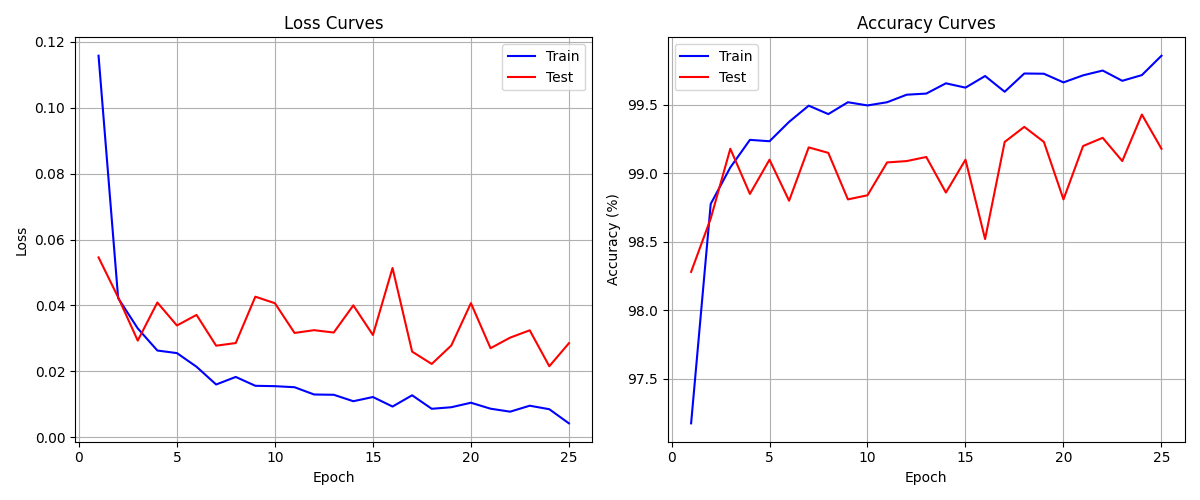

- Confusion Matrix

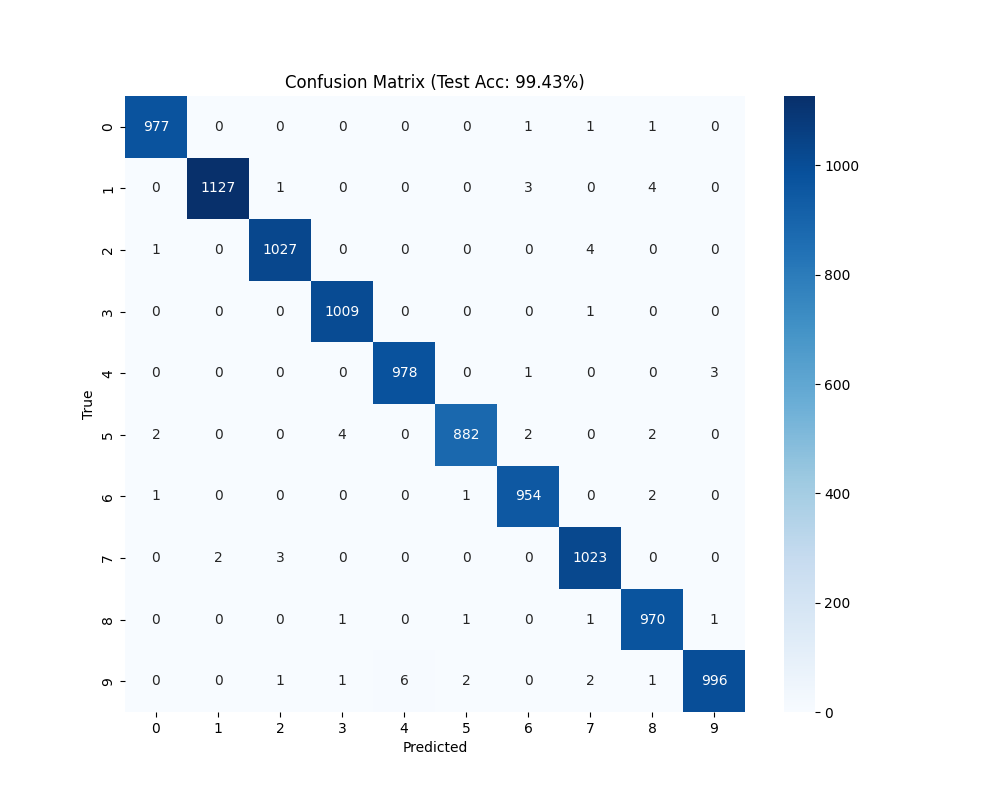

3. For Patch 4

- Training Curve

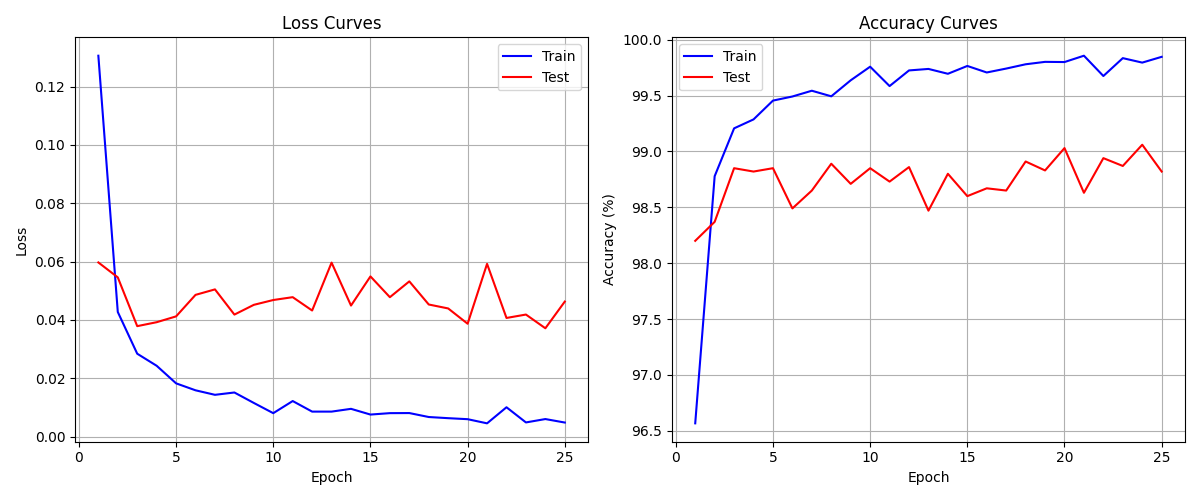

- Confusion Matrix

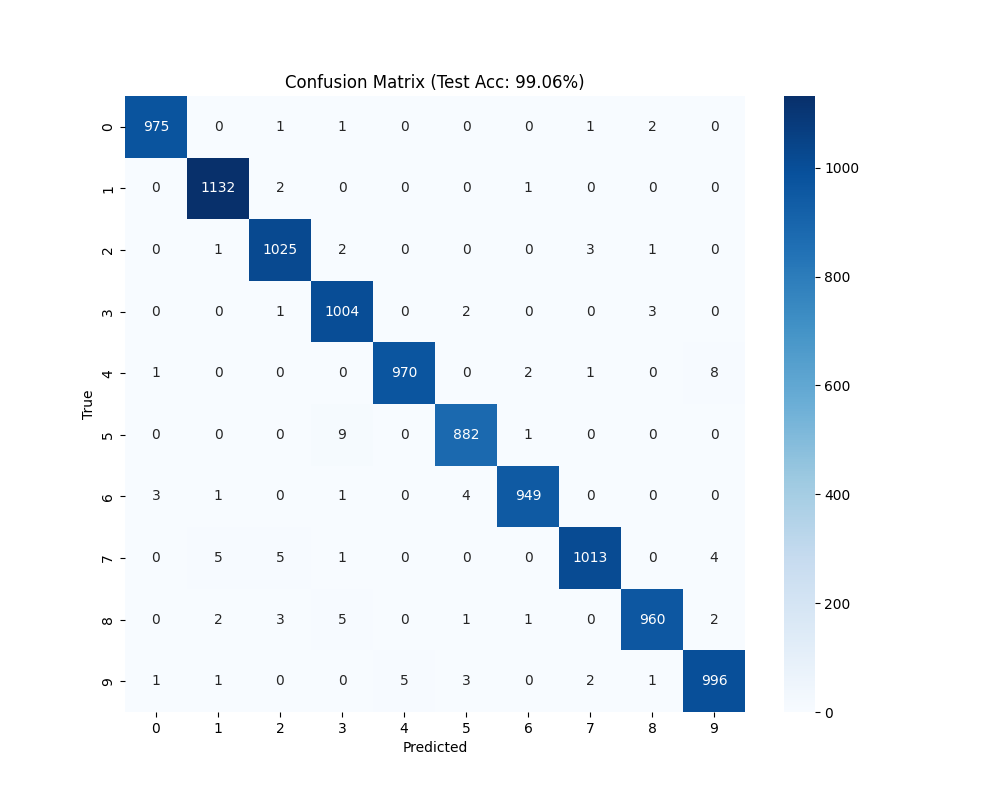

### Key Observations

1. **Overall Performance**:
- All configurations achieved excellent accuracy (>99%)
- The differences between configurations are relatively small (<0.4%)

2. **Patch Size Impact**:
- Smaller patch size (2x2) consistently outperformed larger patch size (4x4)
- patch_size=2 models achieved better final accuracy in both masking ratios

3. **Masking Ratio Effect**:
- For patch_size=2, higher masking ratio (0.85) performed better
- For patch_size=4, lower masking ratio (0.75) performed better

4. **Training Characteristics**:
- Fast convergence in early epochs
- Consistent improvement in both training and test accuracy
- Good generalization with small gaps between training and test performance

## Conclusions

1. **Best Configuration**: patch_size=2 with mask_ratio=0.85 achieved the highest accuracy (99.43%)

2. **Architectural Insights**:
- Smaller patches retain more fine-grained information useful for classification
- Higher masking ratio during pretraining can lead to more robust feature learning

3. **Transfer Learning Effectiveness**:
- Successfully demonstrated that MAE pretraining can be effectively used for downstream classification
- All configurations achieved high accuracy, showing the robustness of the approach

4. **Practical Recommendations**:
- For MNIST classification, use smaller patch sizes (2x2)
- Higher masking ratios during pretraining can be beneficial when using small patches
- The choice between configurations might depend on computational constraints, as smaller patches require more processing

# 3. Experiment with a different dataset, CIFAR-10. Discuss the similarity and differences of the results of both datasets. Suggest possible improvements you could potentially make to CIFAR-10 in the future. ✅

Script used: `cifar10_experiments.py`

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize, RandomHorizontalFlip, RandomCrop
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import os
from A4_MAE import MAE_ViT, ViT_Classifier, setup_seed, denormalize

def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def train_mae_cifar10(patch_size, mask_ratio, num_epochs=50, batch_size=128, device='cuda'):
    # Create directories for saving plots
    plot_dir = f'plots/mae_cifar10_patch{patch_size}_mask{mask_ratio}'
    ensure_dir(plot_dir)
    ensure_dir(os.path.join(plot_dir, 'reconstructions'))
    
    # Data loading with augmentation
    transform_train = Compose([
        RandomCrop(32, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    
    train_dataset = CIFAR10(root='./data', train=True, transform=transform_train, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    # Model setup - modified for RGB images
    model = MAE_ViT(
        image_size=32,
        patch_size=patch_size,
        emb_dim=192,
        encoder_layer=12,
        encoder_head=3,
        decoder_layer=4,
        decoder_head=3,
        mask_ratio=mask_ratio
    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1.5e-4)
    criterion = nn.MSELoss()
    
    # Training loop
    best_loss = float('inf')
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (images, _) in enumerate(progress_bar):
            images = images.to(device)
            
            # Convert RGB to grayscale for current implementation
            images = 0.299 * images[:, 0:1] + 0.587 * images[:, 1:2] + 0.114 * images[:, 2:3]
            
            reconstructed, _ = model(images)
            loss = criterion(reconstructed, images)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
            
            if batch_idx % 200 == 0:
                with torch.no_grad():
                    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
                    for i in range(4):
                        reconstructed_vis, _ = model(images[i:i+1])
                        orig_img = denormalize(images[i].cpu())
                        recon_img = denormalize(reconstructed_vis[0].cpu())
                        
                        axes[0, i].imshow(orig_img.squeeze(), cmap='gray')
                        axes[0, i].axis('off')
                        axes[0, i].set_title('Original')
                        
                        axes[1, i].imshow(recon_img.squeeze(), cmap='gray')
                        axes[1, i].axis('off')
                        axes[1, i].set_title('Reconstructed')
                    
                    plt.tight_layout()
                    plt.savefig(os.path.join(plot_dir, 'reconstructions', f'epoch_{epoch}_batch_{batch_idx}.png'))
                    plt.close()
        
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')
        
        # Plot and save loss curve
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epoch + 2), losses, 'b-')
        plt.title(f'Training Loss (patch_size={patch_size}, mask_ratio={mask_ratio})')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.savefig(os.path.join(plot_dir, 'loss_curve.png'))
        plt.close()
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, f'mae_cifar10_patch{patch_size}_mask{mask_ratio}_best.pth')
    
    return model

def train_classifier_cifar10(pretrained_mae_path, patch_size, num_epochs=30, batch_size=128, device='cuda'):
    # Create directories for saving plots
    plot_dir = f'plots/cifar10_classifier_patch{patch_size}'
    ensure_dir(plot_dir)
    
    # Data loading with augmentation
    transform_train = Compose([
        RandomCrop(32, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    
    transform_test = Compose([
        ToTensor(),
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    
    train_dataset = CIFAR10(root='./data', train=True, transform=transform_train, download=True)
    test_dataset = CIFAR10(root='./data', train=False, transform=transform_test, download=True)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    # Load pretrained MAE
    mae = MAE_ViT(
        image_size=32,
        patch_size=patch_size,
        emb_dim=192,
        encoder_layer=12,
        encoder_head=3,
        decoder_layer=4,
        decoder_head=3,
        mask_ratio=0.75
    ).to(device)
    
    checkpoint = torch.load(pretrained_mae_path, map_location=device)
    mae.load_state_dict(checkpoint['model_state_dict'])
    
    model = ViT_Classifier(mae.encoder, num_classes=10).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Training loop
    best_acc = 0.0
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            # Convert RGB to grayscale
            images = 0.299 * images[:, 0:1] + 0.587 * images[:, 1:2] + 0.114 * images[:, 2:3]
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': 100.*correct/total
            })
        
        scheduler.step()
        train_acc = 100.*correct/total
        train_losses.append(total_loss/len(train_loader))
        train_accs.append(train_acc)
        
        # Evaluation
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                images = 0.299 * images[:, 0:1] + 0.587 * images[:, 1:2] + 0.114 * images[:, 2:3]
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        test_acc = 100.*correct/total
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(test_acc)
        
        print(f'\nEpoch {epoch+1}:')
        print(f'Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_losses[-1]:.4f} | Test Acc: {test_acc:.2f}%')
        
        # Plot and save training curves
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch + 2), train_losses, 'b-', label='Train')
        plt.plot(range(1, epoch + 2), test_losses, 'r-', label='Test')
        plt.title('Loss Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch + 2), train_accs, 'b-', label='Train')
        plt.plot(range(1, epoch + 2), test_accs, 'r-', label='Test')
        plt.title('Accuracy Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, 'training_curves.png'))
        plt.close()
        
        # Save best model and confusion matrix
        if test_acc > best_acc:
            best_acc = test_acc
            
            # Plot confusion matrix for best model
            class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                         'dog', 'frog', 'horse', 'ship', 'truck']
            cm = confusion_matrix(all_labels, all_preds)
            plt.figure(figsize=(12, 10))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=class_names, yticklabels=class_names)
            plt.title(f'Confusion Matrix (Test Acc: {test_acc:.2f}%)')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.xticks(rotation=45)
            plt.yticks(rotation=45)
            plt.tight_layout()
            plt.savefig(os.path.join(plot_dir, 'confusion_matrix.png'))
            plt.close()
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': best_acc,
            }, f'cifar10_classifier_patch{patch_size}_best.pth')
    
    return model, best_acc

if __name__ == "__main__":
    setup_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Experiment configurations
    configs = [
        {'patch_size': 4, 'mask_ratio': 0.75},  # baseline for CIFAR-10
        {'patch_size': 8, 'mask_ratio': 0.75},  # larger patches
        {'patch_size': 4, 'mask_ratio': 0.85},  # more masking
    ]
    
    # Train MAE models
    for config in configs:
        print(f"\nTraining MAE with patch_size={config['patch_size']}, mask_ratio={config['mask_ratio']}")
        train_mae_cifar10(
            patch_size=config['patch_size'],
            mask_ratio=config['mask_ratio'],
            device=device
        )
    
    # Train classifiers
    results = {}
    for config in configs:
        patch_size = config['patch_size']
        mask_ratio = config['mask_ratio']
        mae_path = f'mae_cifar10_patch{patch_size}_mask{mask_ratio}_best.pth'
        
        print(f"\nTraining classifier using MAE with patch_size={patch_size}, mask_ratio={mask_ratio}")
        _, acc = train_classifier_cifar10(mae_path, patch_size, device=device)
        results[f"patch{patch_size}_mask{mask_ratio}"] = acc
    
    # Print final results
    print("\nFinal Results:")
    for config, acc in results.items():
        print(f"{config}: {acc:.2f}%")


```bash
(base) jupyter-st125462@puffer:~/RTML/A4$ python cifar10_experiments.py
/home/jupyter-st125462/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/jupyter-st125462/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 15.92it/s]
In epoch 0, average traning loss is 0.5465917753729415.
=================== EPOCH:  1  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 16.25it/s]
In epoch 1, average traning loss is 0.3796648606657982.
=================== EPOCH:  2  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 15.93it/s]
In epoch 2, average traning loss is 0.31179066192596516.
=================== EPOCH:  3  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 15.99it/s]
In epoch 3, average traning loss is 0.2802716832845769.
=================== EPOCH:  4  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 15.98it/s]
In epoch 4, average traning loss is 0.2737688419032604.
=================== EPOCH:  5  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:12<00:00, 15.52it/s]
In epoch 5, average traning loss is 0.2697553132125672.
=================== EPOCH:  6  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 16.88it/s]
In epoch 6, average traning loss is 0.267296017484462.
=================== EPOCH:  7  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 16.19it/s]
In epoch 7, average traning loss is 0.26577108955763756.
=================== EPOCH:  8  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:11<00:00, 15.68it/s]
In epoch 8, average traning loss is 0.2647874166673802.
=================== EPOCH:  9  ===================
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:12<00:00, 15.60it/s]
In epoch 9, average traning loss is 0.2638680625786173.
=================== EPOCH:  10  ===================

Training MAE with patch_size=4, mask_ratio=0.75
Downloading https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:22<00:00, 7.49MB/s]
Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.18it/s, loss=0.133]
Epoch 1, Average Loss: 0.1752
Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.69it/s, loss=0.108]
Epoch 2, Average Loss: 0.1186
Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.92it/s, loss=0.095]
Epoch 3, Average Loss: 0.1048
Epoch 4/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.07it/s, loss=0.0887]
Epoch 4, Average Loss: 0.0963
Epoch 5/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.10it/s, loss=0.0888]
Epoch 5, Average Loss: 0.0913
Epoch 6/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.91it/s, loss=0.0755]
Epoch 6, Average Loss: 0.0865
Epoch 7/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.85it/s, loss=0.0695]
Epoch 7, Average Loss: 0.0786
Epoch 8/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.71it/s, loss=0.0737]
Epoch 8, Average Loss: 0.0730
Epoch 9/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.25it/s, loss=0.0634]
Epoch 9, Average Loss: 0.0696
Epoch 10/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.45it/s, loss=0.0708]
Epoch 10, Average Loss: 0.0670
Epoch 11/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.95it/s, loss=0.0612]
Epoch 11, Average Loss: 0.0651
Epoch 12/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.43it/s, loss=0.056]
Epoch 12, Average Loss: 0.0639
Epoch 13/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.71it/s, loss=0.0567]
Epoch 13, Average Loss: 0.0629
Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.13it/s, loss=0.063]
Epoch 14, Average Loss: 0.0623
Epoch 15/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.54it/s, loss=0.0611]
Epoch 15, Average Loss: 0.0613
Epoch 16/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.05it/s, loss=0.0642]
Epoch 16, Average Loss: 0.0604
Epoch 17/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.68it/s, loss=0.0558]
Epoch 17, Average Loss: 0.0596
Epoch 18/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.54it/s, loss=0.0579]
Epoch 18, Average Loss: 0.0592
Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.82it/s, loss=0.058]
Epoch 19, Average Loss: 0.0586
Epoch 20/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.85it/s, loss=0.0679]
Epoch 20, Average Loss: 0.0581
Epoch 21/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.34it/s, loss=0.0612]
Epoch 21, Average Loss: 0.0574
Epoch 22/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.05it/s, loss=0.0576]
Epoch 22, Average Loss: 0.0571
Epoch 23/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.47it/s, loss=0.0638]
Epoch 23, Average Loss: 0.0568
Epoch 24/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.02it/s, loss=0.0634]
Epoch 24, Average Loss: 0.0567
Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.13it/s, loss=0.052]
Epoch 25, Average Loss: 0.0566
Epoch 26/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.38it/s, loss=0.0639]
Epoch 26, Average Loss: 0.0559
Epoch 27/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.89it/s, loss=0.0526]
Epoch 27, Average Loss: 0.0558
Epoch 28/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.21it/s, loss=0.0561]
Epoch 28, Average Loss: 0.0557
Epoch 29/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.83it/s, loss=0.0527]
Epoch 29, Average Loss: 0.0552
Epoch 30/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.71it/s, loss=0.0581]
Epoch 30, Average Loss: 0.0552
Epoch 31/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.11it/s, loss=0.0603]
Epoch 31, Average Loss: 0.0549
Epoch 32/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.49it/s, loss=0.051]
Epoch 32, Average Loss: 0.0551
Epoch 33/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.88it/s, loss=0.0541]
Epoch 33, Average Loss: 0.0544
Epoch 34/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.89it/s, loss=0.0578]
Epoch 34, Average Loss: 0.0546
Epoch 35/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.21it/s, loss=0.0567]
Epoch 35, Average Loss: 0.0547
Epoch 36/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.10it/s, loss=0.052]
Epoch 36, Average Loss: 0.0543
Epoch 37/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.77it/s, loss=0.0546]
Epoch 37, Average Loss: 0.0541
Epoch 38/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.47it/s, loss=0.0615]
Epoch 38, Average Loss: 0.0539
Epoch 39/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.29it/s, loss=0.0552]
Epoch 39, Average Loss: 0.0539
Epoch 40/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.09it/s, loss=0.0478]
Epoch 40, Average Loss: 0.0537
Epoch 41/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 15.02it/s, loss=0.0548]
Epoch 41, Average Loss: 0.0535
Epoch 42/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.36it/s, loss=0.0528]
Epoch 42, Average Loss: 0.0534
Epoch 43/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.08it/s, loss=0.0557]
Epoch 43, Average Loss: 0.0533
Epoch 44/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.74it/s, loss=0.0538]
Epoch 44, Average Loss: 0.0534
Epoch 45/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 15.01it/s, loss=0.0472]
Epoch 45, Average Loss: 0.0531
Epoch 46/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.88it/s, loss=0.052]
Epoch 46, Average Loss: 0.0529
Epoch 47/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.27it/s, loss=0.0555]
Epoch 47, Average Loss: 0.0539
Epoch 48/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.94it/s, loss=0.0539]
Epoch 48, Average Loss: 0.0528
Epoch 49/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.17it/s, loss=0.0518]
Epoch 49, Average Loss: 0.0526
Epoch 50/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.62it/s, loss=0.0571]
Epoch 50, Average Loss: 0.0527

Training MAE with patch_size=8, mask_ratio=0.75
Files already downloaded and verified
Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.09it/s, loss=0.142]
Epoch 1, Average Loss: 0.1743
Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.40it/s, loss=0.131]
Epoch 2, Average Loss: 0.1351
Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 15.00it/s, loss=0.112]
Epoch 3, Average Loss: 0.1241
Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.04it/s, loss=0.114]
Epoch 4, Average Loss: 0.1168
Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.45it/s, loss=0.107]
Epoch 5, Average Loss: 0.1119
Epoch 6/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.67it/s, loss=0.119]
Epoch 6, Average Loss: 0.1082
Epoch 7/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.45it/s, loss=0.0965]
Epoch 7, Average Loss: 0.1058
Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.52it/s, loss=0.114]
Epoch 8, Average Loss: 0.1039
Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.56it/s, loss=0.112]
Epoch 9, Average Loss: 0.1022
Epoch 10/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.08it/s, loss=0.106]
Epoch 10, Average Loss: 0.1019
Epoch 11/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.33it/s, loss=0.0969]
Epoch 11, Average Loss: 0.1003
Epoch 12/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.75it/s, loss=0.0957]
Epoch 12, Average Loss: 0.0994
Epoch 13/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.22it/s, loss=0.112]
Epoch 13, Average Loss: 0.0990
Epoch 14/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.50it/s, loss=0.0925]
Epoch 14, Average Loss: 0.0982
Epoch 15/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.32it/s, loss=0.0966]
Epoch 15, Average Loss: 0.0975
Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.83it/s, loss=0.104]
Epoch 16, Average Loss: 0.0974
Epoch 17/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.98it/s, loss=0.0928]
Epoch 17, Average Loss: 0.0972
Epoch 18/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.56it/s, loss=0.102]
Epoch 18, Average Loss: 0.0970
Epoch 19/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.34it/s, loss=0.105]
Epoch 19, Average Loss: 0.0964
Epoch 20/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.49it/s, loss=0.0992]
Epoch 20, Average Loss: 0.0964
Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.06it/s, loss=0.101]
Epoch 21, Average Loss: 0.0956
Epoch 22/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.96it/s, loss=0.0953]
Epoch 22, Average Loss: 0.0954
Epoch 23/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.32it/s, loss=0.0961]
Epoch 23, Average Loss: 0.0955
Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.55it/s, loss=0.103]
Epoch 24, Average Loss: 0.0951
Epoch 25/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.35it/s, loss=0.102]
Epoch 25, Average Loss: 0.0949
Epoch 26/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.89it/s, loss=0.0922]
Epoch 26, Average Loss: 0.0947
Epoch 27/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.14it/s, loss=0.0854]
Epoch 27, Average Loss: 0.0946
Epoch 28/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.52it/s, loss=0.0863]
Epoch 28, Average Loss: 0.0947
Epoch 29/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.41it/s, loss=0.105]
Epoch 29, Average Loss: 0.0941
Epoch 30/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.63it/s, loss=0.0947]
Epoch 30, Average Loss: 0.0942
Epoch 31/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.34it/s, loss=0.106]
Epoch 31, Average Loss: 0.0938
Epoch 32/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.97it/s, loss=0.0849]
Epoch 32, Average Loss: 0.0938
Epoch 33/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.04it/s, loss=0.0874]
Epoch 33, Average Loss: 0.0937
Epoch 34/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.24it/s, loss=0.0983]
Epoch 34, Average Loss: 0.0937
Epoch 35/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.12it/s, loss=0.0873]
Epoch 35, Average Loss: 0.0932
Epoch 36/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.65it/s, loss=0.0981]
Epoch 36, Average Loss: 0.0931
Epoch 37/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.19it/s, loss=0.0901]
Epoch 37, Average Loss: 0.0934
Epoch 38/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.61it/s, loss=0.0872]
Epoch 38, Average Loss: 0.0930
Epoch 39/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.30it/s, loss=0.0947]
Epoch 39, Average Loss: 0.0927
Epoch 40/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.15it/s, loss=0.0957]
Epoch 40, Average Loss: 0.0930
Epoch 41/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.81it/s, loss=0.0862]
Epoch 41, Average Loss: 0.0926
Epoch 42/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.89it/s, loss=0.0842]
Epoch 42, Average Loss: 0.0925
Epoch 43/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.19it/s, loss=0.0961]
Epoch 43, Average Loss: 0.0924
Epoch 44/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.95it/s, loss=0.0865]
Epoch 44, Average Loss: 0.0921
Epoch 45/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.04it/s, loss=0.0852]
Epoch 45, Average Loss: 0.0921
Epoch 46/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.20it/s, loss=0.0985]
Epoch 46, Average Loss: 0.0922
Epoch 47/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.98it/s, loss=0.107]
Epoch 47, Average Loss: 0.0920
Epoch 48/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.61it/s, loss=0.0911]
Epoch 48, Average Loss: 0.0920
Epoch 49/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.24it/s, loss=0.0894]
Epoch 49, Average Loss: 0.0918
Epoch 50/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.10it/s, loss=0.104]
Epoch 50, Average Loss: 0.0920

Training MAE with patch_size=4, mask_ratio=0.85
Files already downloaded and verified
Epoch 1/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.78it/s, loss=0.174]
Epoch 1, Average Loss: 0.2041
Epoch 2/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.16it/s, loss=0.146]
Epoch 2, Average Loss: 0.1541
Epoch 3/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.05it/s, loss=0.138]
Epoch 3, Average Loss: 0.1393
Epoch 4/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.55it/s, loss=0.125]
Epoch 4, Average Loss: 0.1324
Epoch 5/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.41it/s, loss=0.123]
Epoch 5, Average Loss: 0.1272
Epoch 6/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.43it/s, loss=0.11]
Epoch 6, Average Loss: 0.1205
Epoch 7/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:29<00:00, 13.48it/s, loss=0.104]
Epoch 7, Average Loss: 0.1139
Epoch 8/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.66it/s, loss=0.113]
Epoch 8, Average Loss: 0.1104
Epoch 9/50: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.24it/s, loss=0.103]
Epoch 9, Average Loss: 0.1071
Epoch 10/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 22.13it/s, loss=0.0998]
Epoch 10, Average Loss: 0.1056
Epoch 11/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.68it/s, loss=0.0998]
Epoch 11, Average Loss: 0.1044
Epoch 12/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.58it/s, loss=0.0972]
Epoch 12, Average Loss: 0.1034
Epoch 13/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.35it/s, loss=0.0923]
Epoch 13, Average Loss: 0.1025
Epoch 14/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.87it/s, loss=0.101]
Epoch 14, Average Loss: 0.1017
Epoch 15/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.78it/s, loss=0.107]
Epoch 15, Average Loss: 0.1009
Epoch 16/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 16.07it/s, loss=0.101]
Epoch 16, Average Loss: 0.1004
Epoch 17/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.92it/s, loss=0.098]
Epoch 17, Average Loss: 0.0997
Epoch 18/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.79it/s, loss=0.0969]
Epoch 18, Average Loss: 0.0997
Epoch 19/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.95it/s, loss=0.0894]
Epoch 19, Average Loss: 0.0995
Epoch 20/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.17it/s, loss=0.0986]
Epoch 20, Average Loss: 0.0989
Epoch 21/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.27it/s, loss=0.105]
Epoch 21, Average Loss: 0.0986
Epoch 22/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:22<00:00, 17.39it/s, loss=0.103]
Epoch 22, Average Loss: 0.0980
Epoch 23/50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.63it/s, loss=0.1]
Epoch 23, Average Loss: 0.0977
Epoch 24/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.64it/s, loss=0.103]
Epoch 24, Average Loss: 0.0973
Epoch 25/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.21it/s, loss=0.0988]
Epoch 25, Average Loss: 0.0975
Epoch 26/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 15.00it/s, loss=0.0953]
Epoch 26, Average Loss: 0.0970
Epoch 27/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.23it/s, loss=0.0891]
Epoch 27, Average Loss: 0.0965
Epoch 28/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.30it/s, loss=0.103]
Epoch 28, Average Loss: 0.0962
Epoch 29/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.31it/s, loss=0.097]
Epoch 29, Average Loss: 0.0961
Epoch 30/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.97it/s, loss=0.0908]
Epoch 30, Average Loss: 0.0959
Epoch 31/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 15.02it/s, loss=0.0942]
Epoch 31, Average Loss: 0.0960
Epoch 32/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.91it/s, loss=0.097]
Epoch 32, Average Loss: 0.0955
Epoch 33/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.61it/s, loss=0.103]
Epoch 33, Average Loss: 0.0954
Epoch 34/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 14.15it/s, loss=0.101]
Epoch 34, Average Loss: 0.0954
Epoch 35/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.27it/s, loss=0.0924]
Epoch 35, Average Loss: 0.0952
Epoch 36/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.93it/s, loss=0.102]
Epoch 36, Average Loss: 0.0949
Epoch 37/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:26<00:00, 14.67it/s, loss=0.0907]
Epoch 37, Average Loss: 0.0947
Epoch 38/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:27<00:00, 13.97it/s, loss=0.0929]
Epoch 38, Average Loss: 0.0944
Epoch 39/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.79it/s, loss=0.0979]
Epoch 39, Average Loss: 0.0943
Epoch 40/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.27it/s, loss=0.0958]
Epoch 40, Average Loss: 0.0944
Epoch 41/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.76it/s, loss=0.0935]
Epoch 41, Average Loss: 0.0945
Epoch 42/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.69it/s, loss=0.0932]
Epoch 42, Average Loss: 0.0939
Epoch 43/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.50it/s, loss=0.0905]
Epoch 43, Average Loss: 0.0941
Epoch 44/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.36it/s, loss=0.0978]
Epoch 44, Average Loss: 0.0937
Epoch 45/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.30it/s, loss=0.0931]
Epoch 45, Average Loss: 0.0935
Epoch 46/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.48it/s, loss=0.0897]
Epoch 46, Average Loss: 0.0935
Epoch 47/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:24<00:00, 15.84it/s, loss=0.0986]
Epoch 47, Average Loss: 0.0938
Epoch 48/50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.07it/s, loss=0.099]
Epoch 48, Average Loss: 0.0934
Epoch 49/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.63it/s, loss=0.0916]
Epoch 49, Average Loss: 0.0931
Epoch 50/50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.26it/s, loss=0.0943]
Epoch 50, Average Loss: 0.0932

Training classifier using MAE with patch_size=4, mask_ratio=0.75
Files already downloaded and verified
Files already downloaded and verified
/home/jupyter-st125462/RTML/A4/cifar10_experiments.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_mae_path, map_location=device)
Epoch 1/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.94it/s, loss=1.25, acc=44.6]

Epoch 1:
Train Loss: 1.5224 | Train Acc: 44.55%
Test Loss: 1.2337 | Test Acc: 56.52%
Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.91it/s, loss=1.14, acc=57.7]

Epoch 2:
Train Loss: 1.1891 | Train Acc: 57.72%
Test Loss: 1.1123 | Test Acc: 60.27%
Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.79it/s, loss=1.35, acc=62.7]

Epoch 3:
Train Loss: 1.0583 | Train Acc: 62.65%
Test Loss: 0.9933 | Test Acc: 64.85%
Epoch 4/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.85it/s, loss=0.859, acc=65.6]

Epoch 4:
Train Loss: 0.9827 | Train Acc: 65.59%
Test Loss: 0.9327 | Test Acc: 66.93%
Epoch 5/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.68it/s, loss=0.948, acc=67.9]

Epoch 5:
Train Loss: 0.9159 | Train Acc: 67.86%
Test Loss: 0.8763 | Test Acc: 68.80%
Epoch 6/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.56it/s, loss=0.707, acc=69.6]

Epoch 6:
Train Loss: 0.8622 | Train Acc: 69.62%
Test Loss: 0.8523 | Test Acc: 70.07%
Epoch 7/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.81it/s, loss=0.944, acc=71.2]

Epoch 7:
Train Loss: 0.8236 | Train Acc: 71.16%
Test Loss: 0.8322 | Test Acc: 71.04%
Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.71it/s, loss=0.97, acc=72.6]

Epoch 8:
Train Loss: 0.7820 | Train Acc: 72.58%
Test Loss: 0.7909 | Test Acc: 72.30%
Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.51it/s, loss=0.499, acc=74]

Epoch 9:
Train Loss: 0.7481 | Train Acc: 74.00%
Test Loss: 0.7753 | Test Acc: 73.17%
Epoch 10/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.68it/s, loss=0.627, acc=74.7]

Epoch 10:
Train Loss: 0.7248 | Train Acc: 74.67%
Test Loss: 0.7417 | Test Acc: 74.20%
Epoch 11/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.64it/s, loss=0.453, acc=75.9]

Epoch 11:
Train Loss: 0.6899 | Train Acc: 75.91%
Test Loss: 0.7272 | Test Acc: 74.91%
Epoch 12/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.74it/s, loss=0.818, acc=76.9]

Epoch 12:
Train Loss: 0.6618 | Train Acc: 76.85%
Test Loss: 0.7024 | Test Acc: 75.95%
Epoch 13/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.75it/s, loss=0.597, acc=77.6]

Epoch 13:
Train Loss: 0.6417 | Train Acc: 77.56%
Test Loss: 0.6979 | Test Acc: 76.14%
Epoch 14/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.72it/s, loss=0.509, acc=78.5]

Epoch 14:
Train Loss: 0.6156 | Train Acc: 78.53%
Test Loss: 0.6952 | Test Acc: 76.22%
Epoch 15/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:44<00:00,  8.84it/s, loss=0.493, acc=79.3]

Epoch 15:
Train Loss: 0.5959 | Train Acc: 79.28%
Test Loss: 0.6602 | Test Acc: 77.68%
Epoch 16/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:58<00:00,  6.73it/s, loss=0.638, acc=80.1]

Epoch 16:
Train Loss: 0.5708 | Train Acc: 80.09%
Test Loss: 0.6579 | Test Acc: 77.51%
Epoch 17/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:43<00:00,  8.99it/s, loss=0.436, acc=80.7]

Epoch 17:
Train Loss: 0.5517 | Train Acc: 80.71%
Test Loss: 0.6613 | Test Acc: 77.84%
Epoch 18/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:39<00:00,  9.87it/s, loss=0.534, acc=81.4]

Epoch 18:
Train Loss: 0.5333 | Train Acc: 81.39%
Test Loss: 0.6331 | Test Acc: 78.33%
Epoch 19/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.05it/s, loss=0.693, acc=81.7]

Epoch 19:
Train Loss: 0.5206 | Train Acc: 81.70%
Test Loss: 0.6283 | Test Acc: 78.53%
Epoch 20/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.43it/s, loss=0.369, acc=82.6]

Epoch 20:
Train Loss: 0.4992 | Train Acc: 82.57%
Test Loss: 0.6170 | Test Acc: 79.22%
Epoch 21/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.37it/s, loss=0.54, acc=83]

Epoch 21:
Train Loss: 0.4853 | Train Acc: 83.04%
Test Loss: 0.6126 | Test Acc: 79.36%
Epoch 22/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.47it/s, loss=0.55, acc=83.7]

Epoch 22:
Train Loss: 0.4689 | Train Acc: 83.66%
Test Loss: 0.6074 | Test Acc: 79.67%
Epoch 23/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.46it/s, loss=0.552, acc=84.1]

Epoch 23:
Train Loss: 0.4547 | Train Acc: 84.08%
Test Loss: 0.5987 | Test Acc: 79.72%
Epoch 24/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.44it/s, loss=0.443, acc=84.3]

Epoch 24:
Train Loss: 0.4462 | Train Acc: 84.31%
Test Loss: 0.6001 | Test Acc: 79.93%
Epoch 25/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.39it/s, loss=0.673, acc=84.9]

Epoch 25:
Train Loss: 0.4361 | Train Acc: 84.87%
Test Loss: 0.5987 | Test Acc: 79.97%
Epoch 26/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.30it/s, loss=0.438, acc=85]

Epoch 26:
Train Loss: 0.4254 | Train Acc: 84.99%
Test Loss: 0.5960 | Test Acc: 80.18%
Epoch 27/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.31it/s, loss=0.444, acc=85.3]

Epoch 27:
Train Loss: 0.4183 | Train Acc: 85.32%
Test Loss: 0.5936 | Test Acc: 80.30%
Epoch 28/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.43it/s, loss=0.484, acc=85.2]

Epoch 28:
Train Loss: 0.4227 | Train Acc: 85.17%
Test Loss: 0.5929 | Test Acc: 80.35%
Epoch 29/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:38<00:00, 10.16it/s, loss=0.425, acc=85.5]

Epoch 29:
Train Loss: 0.4150 | Train Acc: 85.51%
Test Loss: 0.5901 | Test Acc: 80.52%
Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:37<00:00, 10.39it/s, loss=0.327, acc=85.5]

Epoch 30:
Train Loss: 0.4142 | Train Acc: 85.54%
Test Loss: 0.5901 | Test Acc: 80.44%

Training classifier using MAE with patch_size=8, mask_ratio=0.75
Files already downloaded and verified
Files already downloaded and verified
/home/jupyter-st125462/RTML/A4/cifar10_experiments.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_mae_path, map_location=device)
Epoch 1/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.05it/s, loss=1.63, acc=38.7]

Epoch 1:
Train Loss: 1.6767 | Train Acc: 38.72%
Test Loss: 1.4968 | Test Acc: 45.71%
Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.02it/s, loss=1.38, acc=48.1]

Epoch 2:
Train Loss: 1.4398 | Train Acc: 48.05%
Test Loss: 1.3511 | Test Acc: 51.20%
Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.67it/s, loss=1.19, acc=52.4]

Epoch 3:
Train Loss: 1.3330 | Train Acc: 52.37%
Test Loss: 1.2676 | Test Acc: 54.82%
Epoch 4/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.53it/s, loss=1.4, acc=55.3]

Epoch 4:
Train Loss: 1.2583 | Train Acc: 55.33%
Test Loss: 1.2072 | Test Acc: 57.30%
Epoch 5/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.08it/s, loss=1.46, acc=57.5]

Epoch 5:
Train Loss: 1.2008 | Train Acc: 57.47%
Test Loss: 1.1673 | Test Acc: 58.82%
Epoch 6/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.70it/s, loss=1.12, acc=58.9]

Epoch 6:
Train Loss: 1.1588 | Train Acc: 58.93%
Test Loss: 1.1361 | Test Acc: 59.49%
Epoch 7/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.46it/s, loss=1.41, acc=60.5]

Epoch 7:
Train Loss: 1.1139 | Train Acc: 60.50%
Test Loss: 1.0755 | Test Acc: 62.32%
Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.74it/s, loss=1.03, acc=61.5]

Epoch 8:
Train Loss: 1.0849 | Train Acc: 61.51%
Test Loss: 1.0650 | Test Acc: 62.56%
Epoch 9/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.03it/s, loss=0.859, acc=62.9]

Epoch 9:
Train Loss: 1.0479 | Train Acc: 62.87%
Test Loss: 1.0440 | Test Acc: 63.21%
Epoch 10/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.77it/s, loss=0.814, acc=63.6]

Epoch 10:
Train Loss: 1.0240 | Train Acc: 63.64%
Test Loss: 1.0225 | Test Acc: 64.03%
Epoch 11/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.38it/s, loss=0.99, acc=64.7]

Epoch 11:
Train Loss: 0.9965 | Train Acc: 64.67%
Test Loss: 0.9924 | Test Acc: 65.24%
Epoch 12/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.10it/s, loss=1.03, acc=65.8]

Epoch 12:
Train Loss: 0.9699 | Train Acc: 65.77%
Test Loss: 0.9715 | Test Acc: 65.79%
Epoch 13/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.01it/s, loss=0.972, acc=66.6]

Epoch 13:
Train Loss: 0.9474 | Train Acc: 66.59%
Test Loss: 0.9578 | Test Acc: 66.63%
Epoch 14/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.67it/s, loss=1.08, acc=67.5]

Epoch 14:
Train Loss: 0.9235 | Train Acc: 67.50%
Test Loss: 0.9380 | Test Acc: 67.52%
Epoch 15/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.10it/s, loss=1.15, acc=68]

Epoch 15:
Train Loss: 0.9023 | Train Acc: 67.97%
Test Loss: 0.9320 | Test Acc: 67.34%
Epoch 16/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.99it/s, loss=0.898, acc=68.8]

Epoch 16:
Train Loss: 0.8854 | Train Acc: 68.85%
Test Loss: 0.9137 | Test Acc: 67.89%
Epoch 17/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.37it/s, loss=0.857, acc=69.5]

Epoch 17:
Train Loss: 0.8638 | Train Acc: 69.49%
Test Loss: 0.8924 | Test Acc: 68.85%
Epoch 18/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.91it/s, loss=0.744, acc=70.1]

Epoch 18:
Train Loss: 0.8458 | Train Acc: 70.10%
Test Loss: 0.8834 | Test Acc: 69.17%
Epoch 19/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.45it/s, loss=0.711, acc=70.8]

Epoch 19:
Train Loss: 0.8242 | Train Acc: 70.75%
Test Loss: 0.8762 | Test Acc: 69.24%
Epoch 20/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.40it/s, loss=0.917, acc=71.3]

Epoch 20:
Train Loss: 0.8122 | Train Acc: 71.29%
Test Loss: 0.8651 | Test Acc: 69.53%
Epoch 21/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 17.91it/s, loss=0.717, acc=71.7]

Epoch 21:
Train Loss: 0.8007 | Train Acc: 71.68%
Test Loss: 0.8568 | Test Acc: 70.11%
Epoch 22/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:21<00:00, 18.50it/s, loss=0.892, acc=72.2]

Epoch 22:
Train Loss: 0.7888 | Train Acc: 72.22%
Test Loss: 0.8479 | Test Acc: 70.27%
Epoch 23/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.30it/s, loss=0.826, acc=72.8]

Epoch 23:
Train Loss: 0.7728 | Train Acc: 72.82%
Test Loss: 0.8383 | Test Acc: 70.92%
Epoch 24/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.46it/s, loss=0.631, acc=73]

Epoch 24:
Train Loss: 0.7640 | Train Acc: 72.97%
Test Loss: 0.8381 | Test Acc: 70.78%
Epoch 25/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.09it/s, loss=0.99, acc=73.5]

Epoch 25:
Train Loss: 0.7537 | Train Acc: 73.52%
Test Loss: 0.8303 | Test Acc: 71.12%
Epoch 26/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.22it/s, loss=0.914, acc=73.5]

Epoch 26:
Train Loss: 0.7496 | Train Acc: 73.49%
Test Loss: 0.8303 | Test Acc: 71.24%
Epoch 27/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 19.02it/s, loss=0.628, acc=73.9]

Epoch 27:
Train Loss: 0.7417 | Train Acc: 73.88%
Test Loss: 0.8237 | Test Acc: 71.41%
Epoch 28/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.67it/s, loss=0.658, acc=73.9]

Epoch 28:
Train Loss: 0.7389 | Train Acc: 73.90%
Test Loss: 0.8225 | Test Acc: 71.45%
Epoch 29/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:20<00:00, 18.77it/s, loss=0.67, acc=74]

Epoch 29:
Train Loss: 0.7336 | Train Acc: 73.99%
Test Loss: 0.8218 | Test Acc: 71.35%
Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 19.81it/s, loss=0.663, acc=74.1]

Epoch 30:
Train Loss: 0.7318 | Train Acc: 74.13%
Test Loss: 0.8211 | Test Acc: 71.36%

Training classifier using MAE with patch_size=4, mask_ratio=0.85
Files already downloaded and verified
Files already downloaded and verified
/home/jupyter-st125462/RTML/A4/cifar10_experiments.py:156: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_mae_path, map_location=device)
Epoch 1/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.78it/s, loss=1.46, acc=43.8]

Epoch 1:
Train Loss: 1.5549 | Train Acc: 43.77%
Test Loss: 1.2907 | Test Acc: 53.93%
Epoch 2/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.58it/s, loss=1.23, acc=56.4]

Epoch 2:
Train Loss: 1.2227 | Train Acc: 56.43%
Test Loss: 1.1171 | Test Acc: 60.46%
Epoch 3/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.78it/s, loss=1.13, acc=61.1]

Epoch 3:
Train Loss: 1.1023 | Train Acc: 61.13%
Test Loss: 1.0444 | Test Acc: 62.93%
Epoch 4/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.72it/s, loss=1.01, acc=64]

Epoch 4:
Train Loss: 1.0236 | Train Acc: 64.01%
Test Loss: 0.9837 | Test Acc: 65.71%
Epoch 5/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.73it/s, loss=0.803, acc=66.1]

Epoch 5:
Train Loss: 0.9620 | Train Acc: 66.05%
Test Loss: 0.9458 | Test Acc: 66.64%
Epoch 6/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.57it/s, loss=0.943, acc=67.7]

Epoch 6:
Train Loss: 0.9185 | Train Acc: 67.74%
Test Loss: 0.8755 | Test Acc: 69.29%
Epoch 7/30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.71it/s, loss=1, acc=69.2]

Epoch 7:
Train Loss: 0.8757 | Train Acc: 69.25%
Test Loss: 0.8768 | Test Acc: 69.55%
Epoch 8/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.68it/s, loss=0.69, acc=70.9]

Epoch 8:
Train Loss: 0.8338 | Train Acc: 70.94%
Test Loss: 0.8459 | Test Acc: 70.12%
Epoch 9/30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.57it/s, loss=1.1, acc=71.8]

Epoch 9:
Train Loss: 0.8014 | Train Acc: 71.75%
Test Loss: 0.8145 | Test Acc: 71.78%
Epoch 10/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.43it/s, loss=0.797, acc=72.8]

Epoch 10:
Train Loss: 0.7754 | Train Acc: 72.85%
Test Loss: 0.7858 | Test Acc: 72.33%
Epoch 11/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.80it/s, loss=0.538, acc=74.1]

Epoch 11:
Train Loss: 0.7412 | Train Acc: 74.14%
Test Loss: 0.7648 | Test Acc: 73.16%
Epoch 12/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.51it/s, loss=0.701, acc=75]

Epoch 12:
Train Loss: 0.7105 | Train Acc: 74.96%
Test Loss: 0.7612 | Test Acc: 73.78%
Epoch 13/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.71it/s, loss=0.611, acc=76]

Epoch 13:
Train Loss: 0.6835 | Train Acc: 75.98%
Test Loss: 0.7347 | Test Acc: 74.50%
Epoch 14/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:23<00:00, 16.56it/s, loss=0.718, acc=76.8]

Epoch 14:
Train Loss: 0.6595 | Train Acc: 76.79%
Test Loss: 0.7197 | Test Acc: 75.14%
Epoch 15/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:43<00:00,  9.08it/s, loss=0.541, acc=77.6]

Epoch 15:
Train Loss: 0.6373 | Train Acc: 77.57%
Test Loss: 0.6998 | Test Acc: 76.01%
Epoch 16/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.67it/s, loss=0.526, acc=78.3]

Epoch 16:
Train Loss: 0.6153 | Train Acc: 78.28%
Test Loss: 0.6978 | Test Acc: 75.46%
Epoch 17/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.68it/s, loss=0.612, acc=79.2]

Epoch 17:
Train Loss: 0.5947 | Train Acc: 79.22%
Test Loss: 0.6949 | Test Acc: 75.80%
Epoch 18/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.64it/s, loss=0.571, acc=79.7]

Epoch 18:
Train Loss: 0.5752 | Train Acc: 79.72%
Test Loss: 0.6708 | Test Acc: 76.97%
Epoch 19/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.65it/s, loss=0.456, acc=80.5]

Epoch 19:
Train Loss: 0.5553 | Train Acc: 80.52%
Test Loss: 0.6640 | Test Acc: 77.44%
Epoch 20/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.62it/s, loss=0.521, acc=81.1]

Epoch 20:
Train Loss: 0.5369 | Train Acc: 81.09%
Test Loss: 0.6658 | Test Acc: 77.01%
Epoch 21/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.65it/s, loss=0.545, acc=81.9]

Epoch 21:
Train Loss: 0.5161 | Train Acc: 81.85%
Test Loss: 0.6571 | Test Acc: 77.65%
Epoch 22/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.60it/s, loss=0.608, acc=82.3]

Epoch 22:
Train Loss: 0.5053 | Train Acc: 82.34%
Test Loss: 0.6484 | Test Acc: 78.00%
Epoch 23/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.64it/s, loss=0.354, acc=82.8]

Epoch 23:
Train Loss: 0.4919 | Train Acc: 82.81%
Test Loss: 0.6514 | Test Acc: 78.09%
Epoch 24/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.62it/s, loss=0.516, acc=83.1]

Epoch 24:
Train Loss: 0.4828 | Train Acc: 83.14%
Test Loss: 0.6373 | Test Acc: 78.57%
Epoch 25/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.54it/s, loss=0.367, acc=83.6]

Epoch 25:
Train Loss: 0.4704 | Train Acc: 83.57%
Test Loss: 0.6395 | Test Acc: 78.68%
Epoch 26/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.60it/s, loss=0.561, acc=83.8]

Epoch 26:
Train Loss: 0.4640 | Train Acc: 83.82%
Test Loss: 0.6359 | Test Acc: 78.71%
Epoch 27/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.52it/s, loss=0.502, acc=83.8]

Epoch 27:
Train Loss: 0.4613 | Train Acc: 83.83%
Test Loss: 0.6378 | Test Acc: 78.61%
Epoch 28/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:45<00:00,  8.60it/s, loss=0.481, acc=84.3]

Epoch 28:
Train Loss: 0.4515 | Train Acc: 84.26%
Test Loss: 0.6321 | Test Acc: 78.83%
Epoch 29/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.48it/s, loss=0.378, acc=84.4]

Epoch 29:
Train Loss: 0.4490 | Train Acc: 84.37%
Test Loss: 0.6314 | Test Acc: 78.85%
Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:46<00:00,  8.47it/s, loss=0.417, acc=84.3]

Epoch 30:
Train Loss: 0.4453 | Train Acc: 84.32%
Test Loss: 0.6310 | Test Acc: 78.99%

Final Results:
patch4_mask0.75: 80.52%
patch8_mask0.75: 71.45%
patch4_mask0.85: 78.99%
```

# Summary of Analysis

## Plots & Visualizations:

1. Patch 4 Mask 0.75

- 25th Epoch

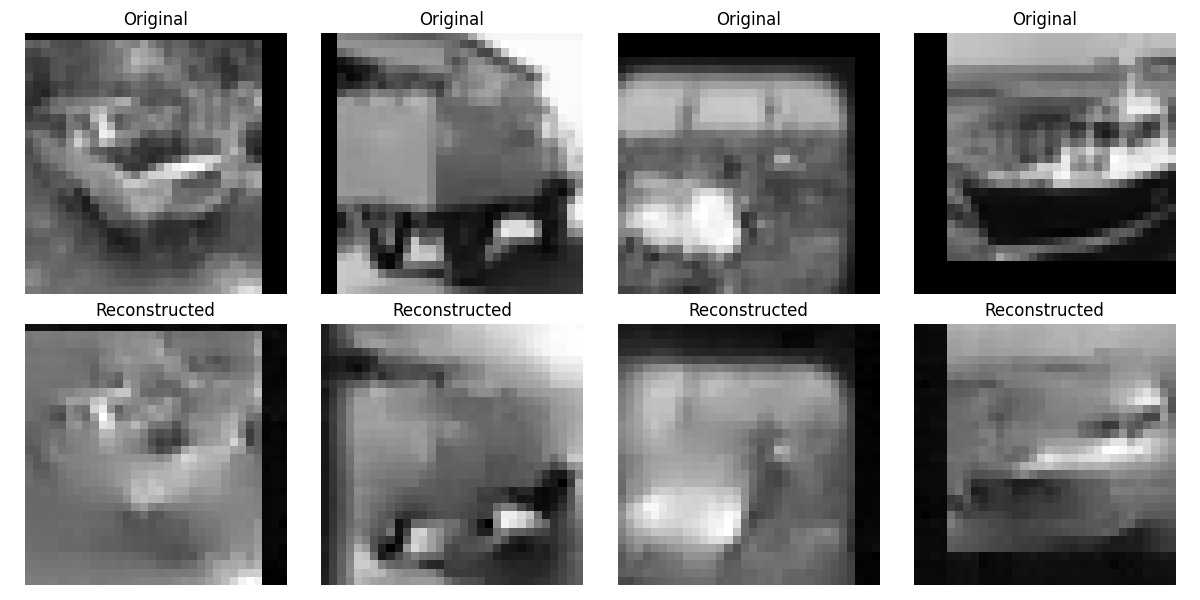

- Loss Curve

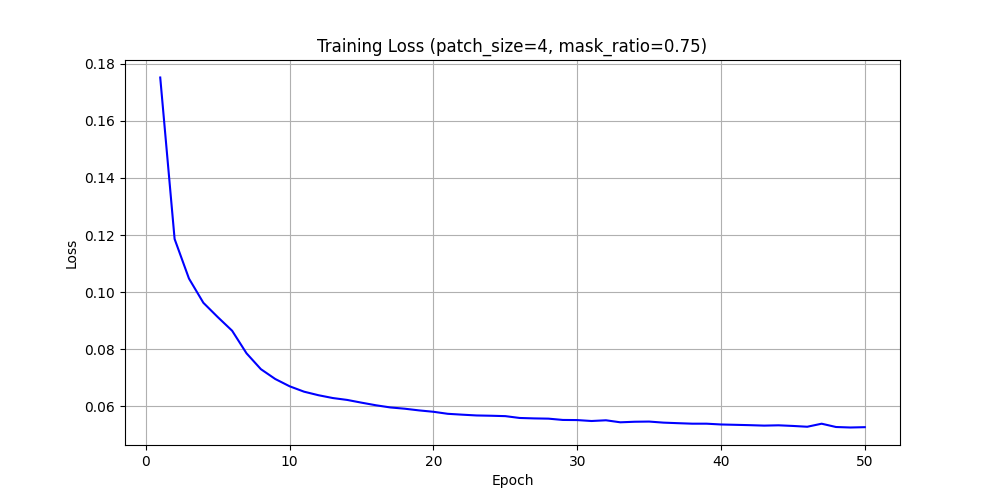

2. Patch 4 Mask 0.85

- 25th Epoch

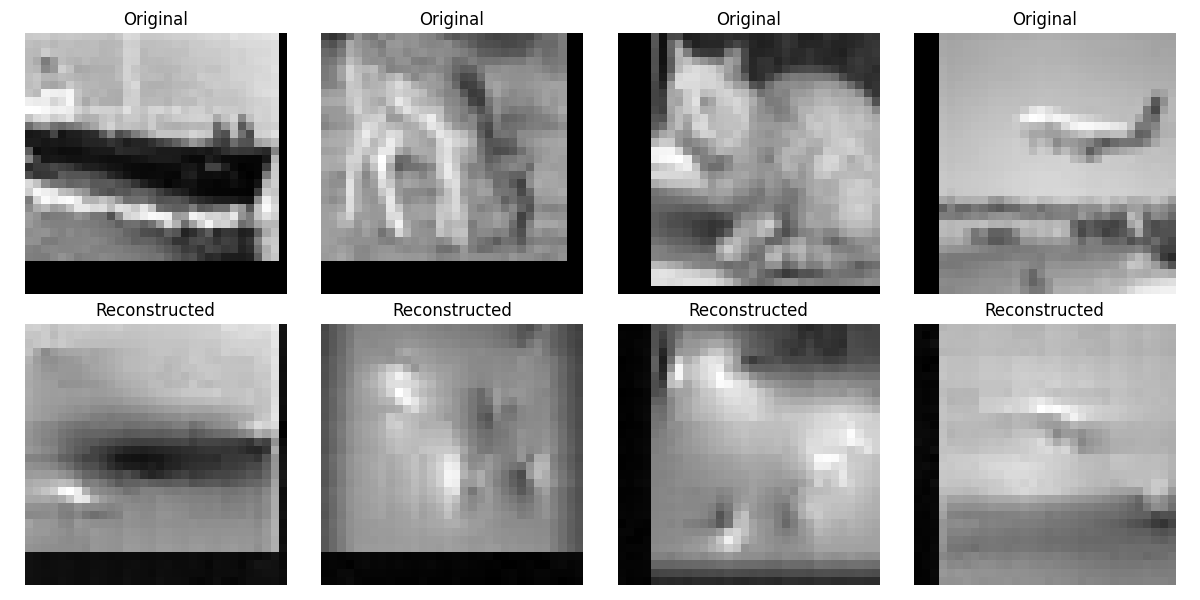

- Loss Curve

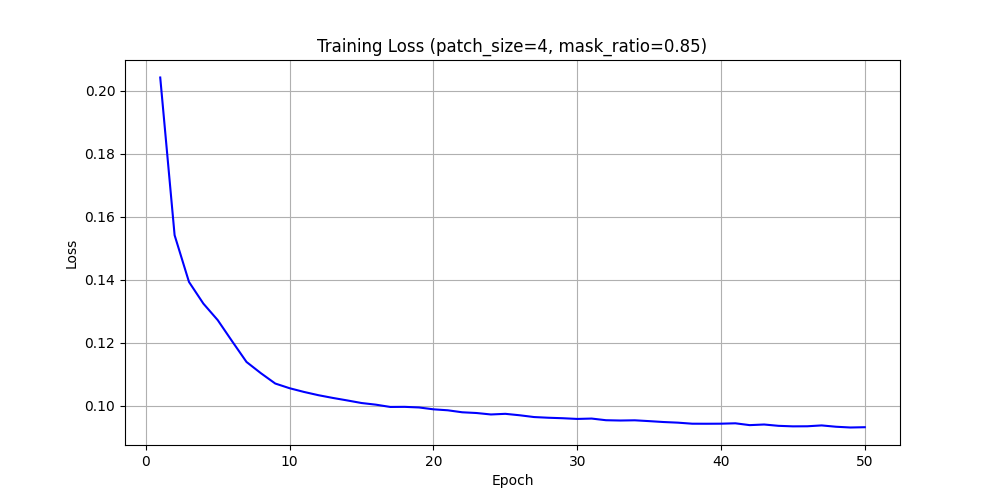

3. Patch 8 Mask 0.75

- 25th Epoch
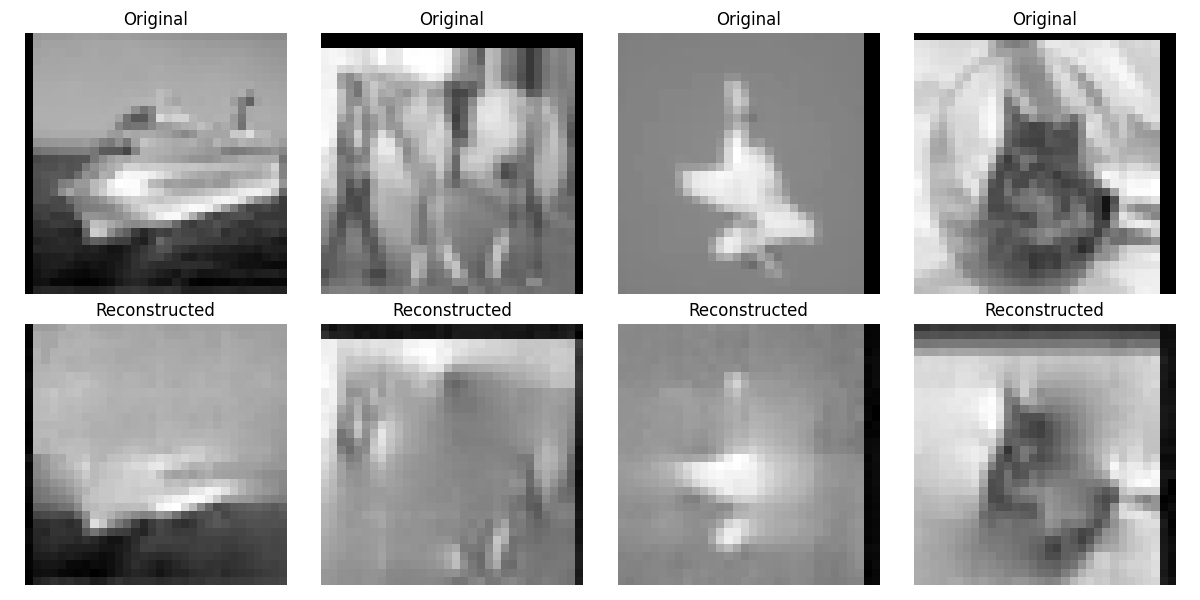  

- Loss Curve
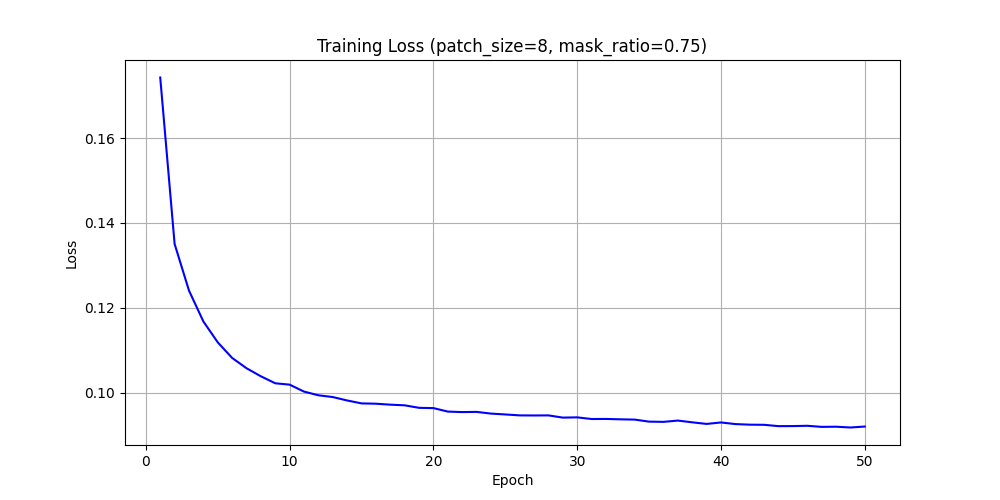

4. Classifier Patch 4

- Confusion Matrix

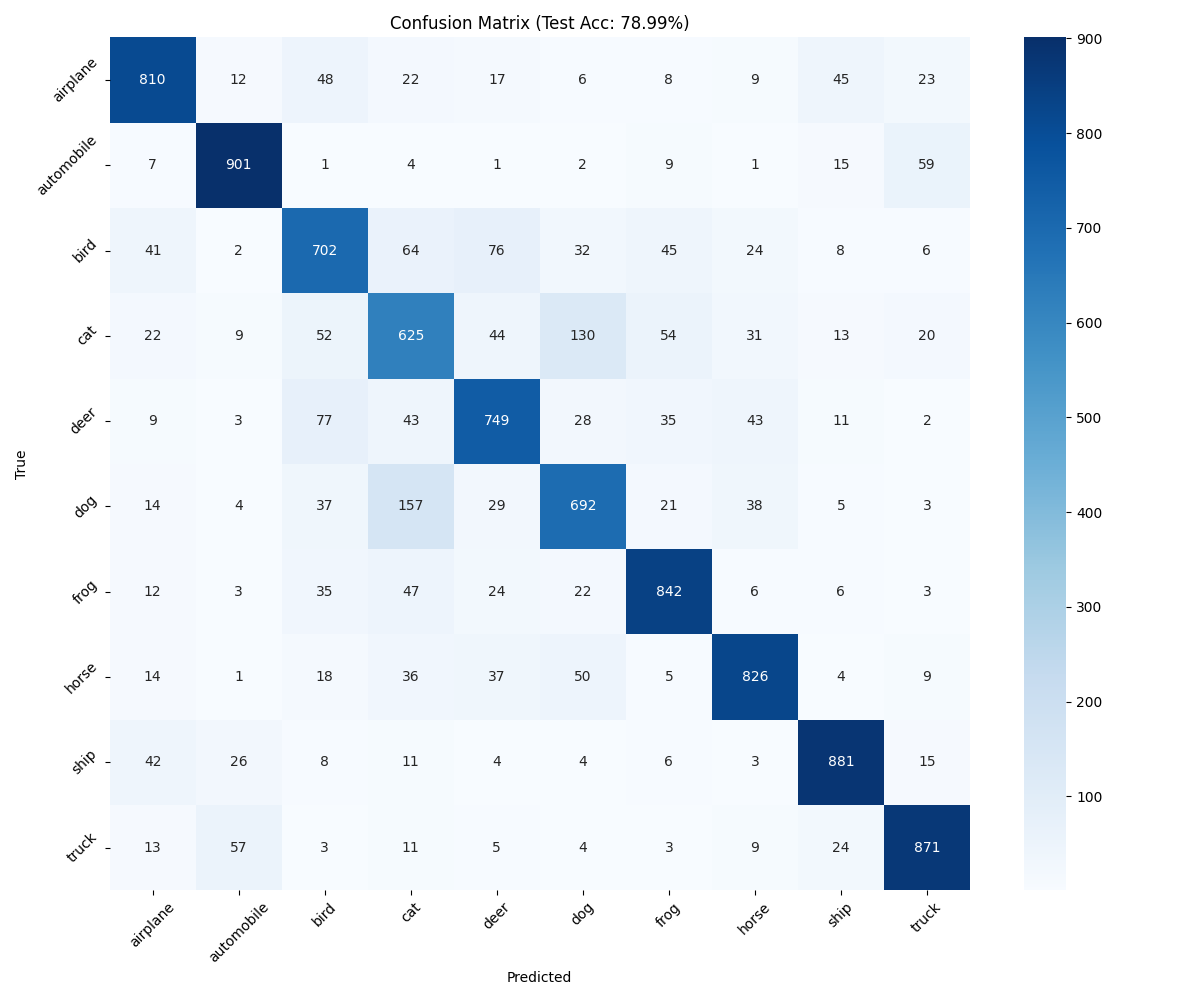

- Training Curve
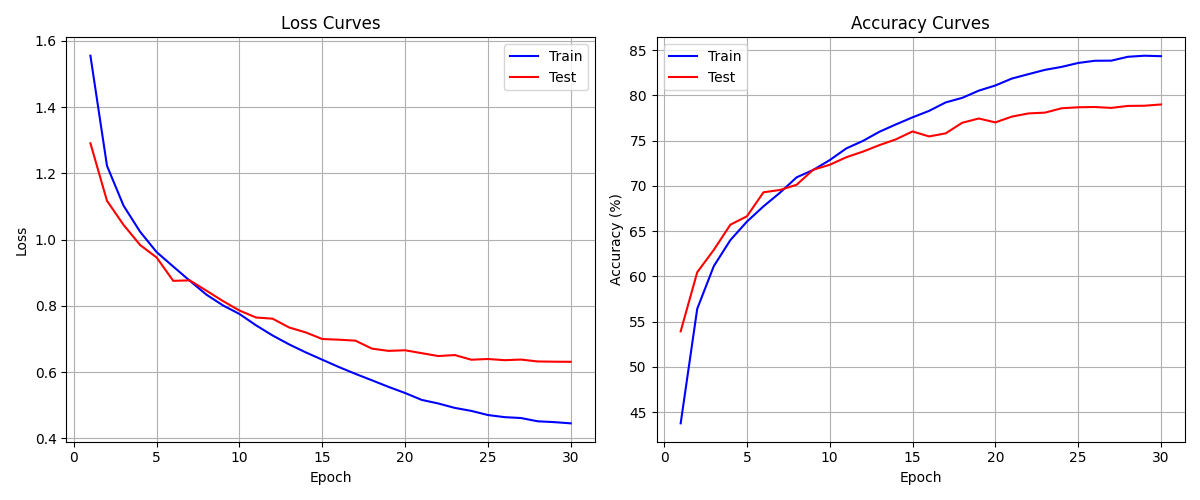

5. Classifier Patch 8

- Confusion matrix
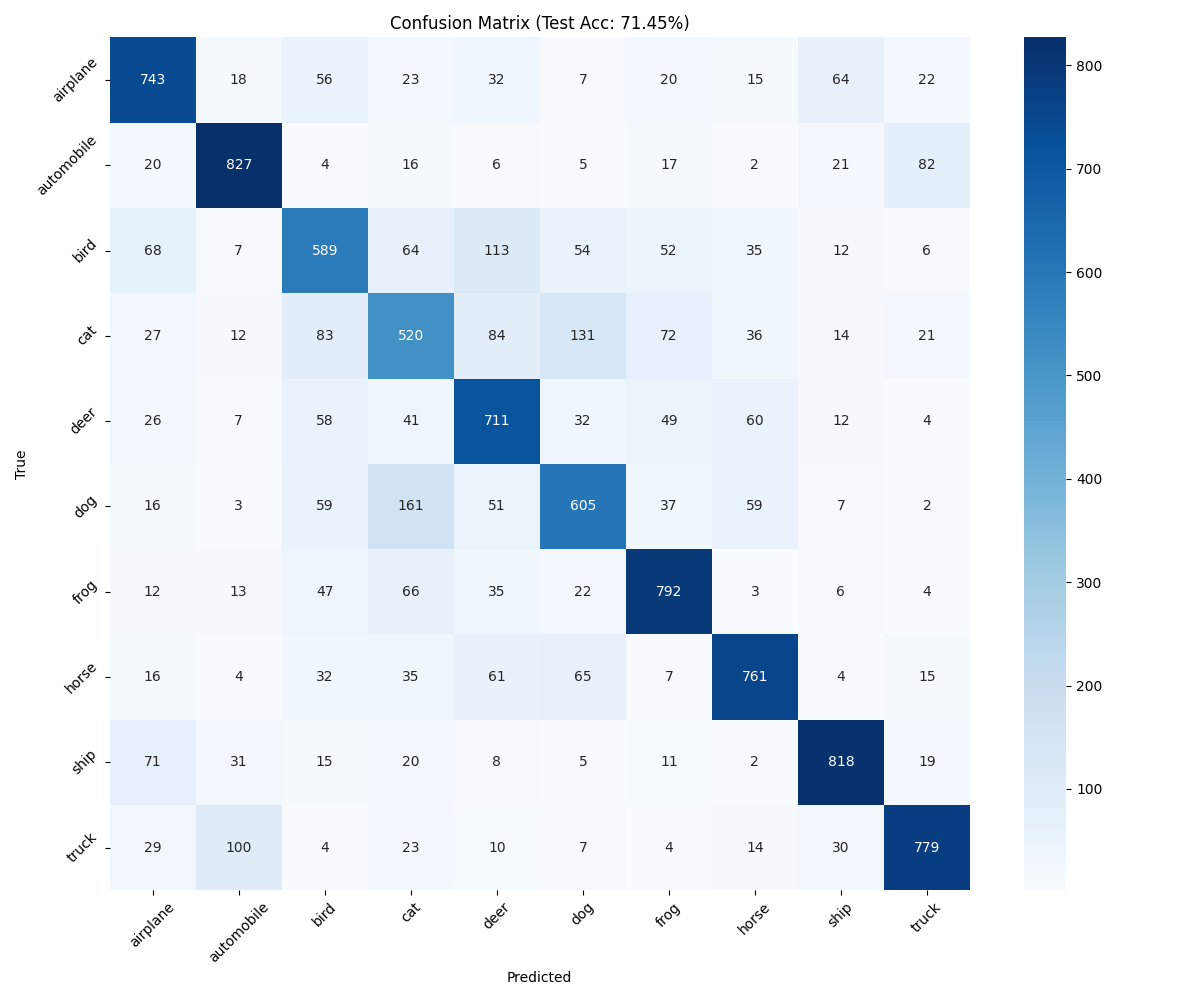  

- Training Curve
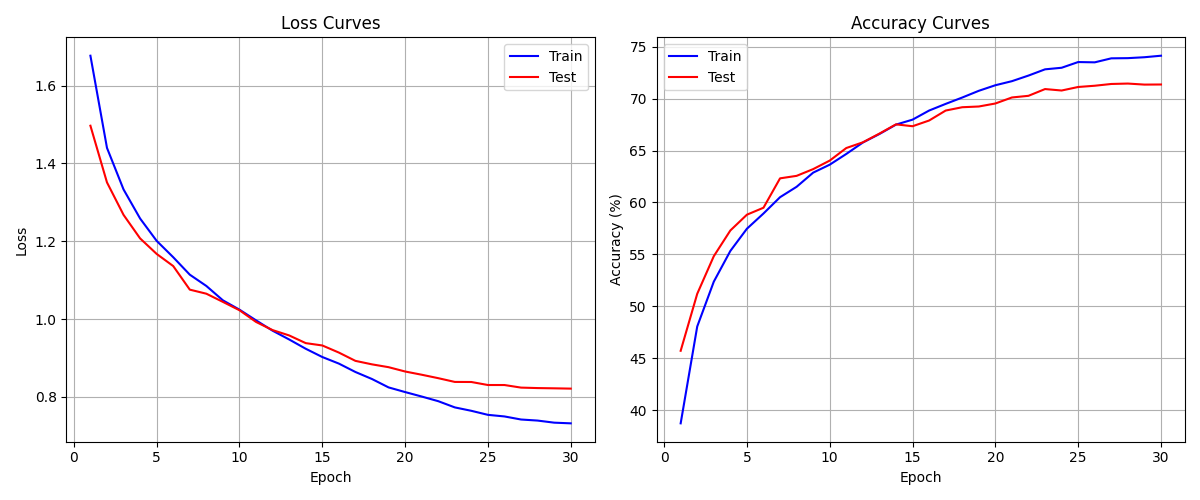

## Key Differences Between MNIST and CIFAR-10 Results

**Training Performance**:
- MNIST achieved much higher accuracy (>99%) compared to CIFAR-10's peak accuracy of around 80%
- CIFAR-10 showed slower convergence and required more epochs to reach optimal performance
- MNIST training was more stable with consistent improvements, while CIFAR-10 showed more fluctuations in loss

**Patch Size Impact**:
- For MNIST, smaller patch sizes (2x2) performed better than larger ones
- For CIFAR-10, patch_size=4 achieved better results than patch_size=8, suggesting an optimal middle ground
- The impact of patch size was more pronounced in CIFAR-10 than MNIST

**Masking Ratio Effects**:
- MNIST was relatively robust to different masking ratios
- CIFAR-10 showed more sensitivity to masking ratios, with performance degrading more significantly at higher ratios

## Reasons for Differences

1. **Dataset Complexity**:
- MNIST contains simple grayscale digits
- CIFAR-10 has complex RGB images with varied objects, backgrounds, and orientations

2. **Feature Extraction**:
- MNIST features are more structured and consistent
- CIFAR-10 requires learning more sophisticated features across multiple channels

## Suggested Improvements for CIFAR-10

1. **Architecture Enhancements**:
- Increase model capacity (more layers, wider networks)
- Implement hierarchical feature learning
- Add skip connections for better gradient flow

2. **Training Optimizations**:
- Implement progressive learning strategies
- Use curriculum learning with increasing image complexity
- Employ more sophisticated data augmentation techniques

3. **Hyperparameter Refinements**:
- Experiment with smaller patch sizes (3x3, 5x5)
- Test adaptive masking ratios during training
- Optimize learning rate schedules for better convergence

4. **Data Processing**:
- Implement advanced normalization techniques
- Add color jittering and other image transformations
- Use mixup or cutmix augmentation strategies

These improvements could potentially help bridge the performance gap between MNIST and CIFAR-10 results while maintaining computational efficiency.

# Thank You 🤗
 
Here's the Github Repository Link: https://github.com/aryashah2k/RTML/tree/main/A4

Model Checkpoints and Weights can be downloaded from the Terabox Drive here: https://1024terabox.com/s/1oVd_BW1hXFFbCCwNlUw6JQ